### Assignment: State space models ###
Use your time series of the log of real GDP, seasonally adjusted, and estimate the trend/cycle model.

1. In the attachment to this assignment you have two versions (with and without MLE estimation) of the code for replication without any comments. 

Compare these two models. 
Comment on the code explaining the step-by-step process. 
Even if you don't understand all lines of the code, focus on the explanation of the Kalman filter. Denote the initialization of the filter, then the prediction, updating, and smoothing. Show, where the loops appear, and why the loops are necessary.
The presentation of the problem set is obligatory.
Hint: The model without MLE is calculated for the "GUESSED" parameters only,  the MLE is used to estimate the best parameter choice. I have uploaded the original data for the reference. Do not forget to use the data for your chosen country. 



Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Attaching package: ‘neverhpfilter’

The following object is masked from ‘package:MASS’:

    SP500

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘dplyr’

The following objects are masked from ‘package:xts’:

    first, last

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:reshape2’:

    smiths



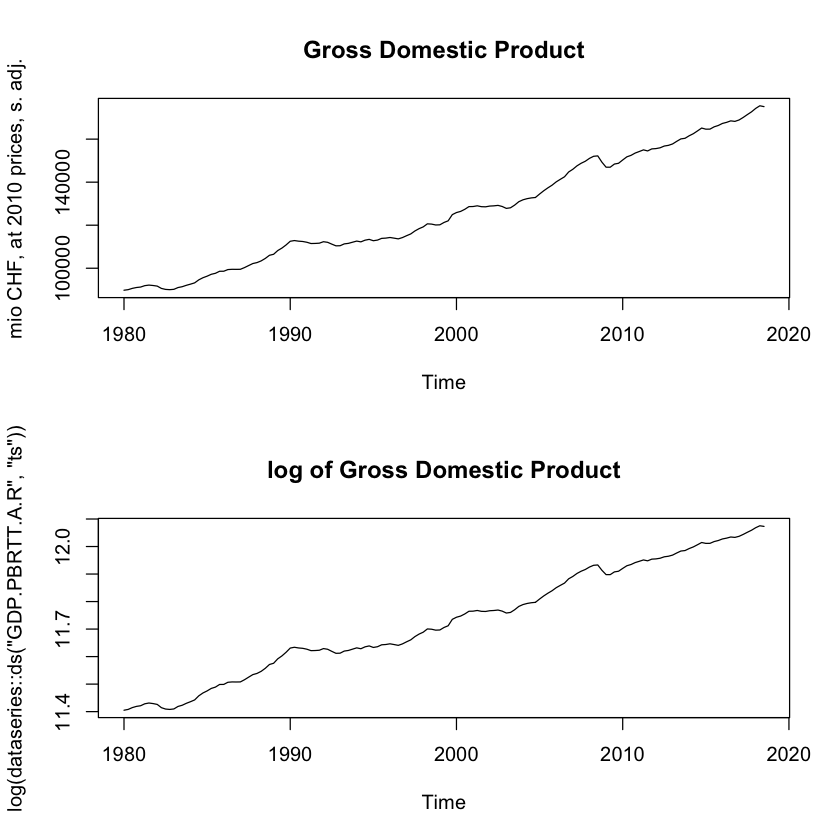

In [5]:
#loading packages
library(reshape2)
library(neverhpfilter)
library(xts)
library(mFilter)
library(dplyr)
library(tidyr)

par(mfrow=c(2,1))

#loading GDP of Switzerland, seasonally adjusted, in mio CHF, 2010 prices
plot(dataseries::ds("GDP.PBRTT.A.R", "ts"), 
     ylab = "mio CHF, at 2010 prices, s. adj.", 
     main = "Gross Domestic Product")
plot(log(dataseries::ds("GDP.PBRTT.A.R", "ts")), 
     main = "log of Gross Domestic Product")
ds1 <- dataseries::ds("GDP.PBRTT.A.R", "ts")
#taking log
ds2 <- log(ds1)
#taking log differences

### Unfortunately I had some issues I could not resolve while trying to use my previous data in this code. I decided to stick with data provided by you instead. ###

## Model 1: Without MLE ##

Header

In [6]:
# BCT Winter 2019
# November 6, 2019
# STATE-SPACE MODELS AND KALMAN FILTER

# APPLICATION: SIMPLE ESTIMATION OF GDP GAP
#     ... USING TREND - CYCLE MODEL

Setting up variables to be used further

In [7]:
#### HOUSEKEEPING ####
rm(list = ls())

#### DATA ####
gdp   <- library(readxl)
gdp   <- na.omit(read_excel("gdpCZ.xlsx"))
dates <- gdp$period
gdp   <- log(gdp$value)
gdpG  <- c(0,diff(gdp))

Plotting data

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


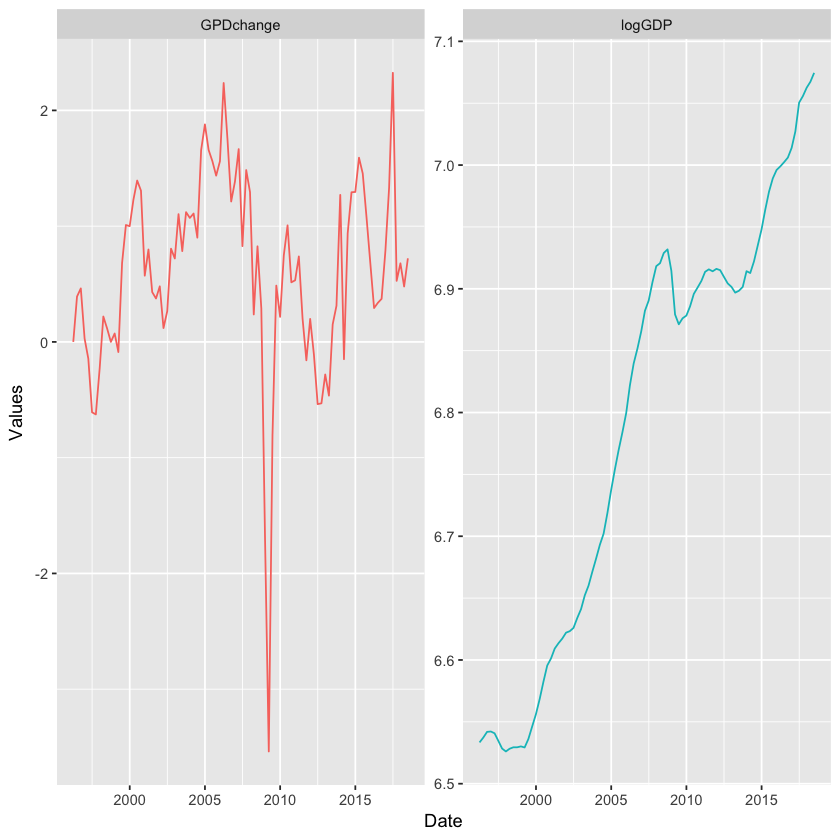

In [8]:
# Prepare nice ggplot #
library(ggplot2)
data.plot = data.frame(Date     = rep(dates,2),
                       Category = rep(c("logGDP","GPDchange"), each=length(gdp)),
                       Values   = c(gdp,gdpG*100))

ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                              geom_line(aes(color=Category)) + 
                       facet_wrap(~ Category, scales='free') + 
                               theme(legend.position="none")

Background to the model

In [9]:
#### STORY ####
# some of the dynamics is driven by potential GDP, some by some cyclical fluctuations (GDP gap)
# we are interested in the potential, which is, however, unobservable
# consequently, we will try to estimate the potential as a state variable in the state-space model

#### MACRO-MODELLING ####

# SPACE of models --> model selection --> parameter estimation

# ARIMA models ... I have a small SPACE of possible models defined by the AR/MA/D orders
#                  the only structure imposed is that the residuals are white noise
#                  otherwise all is data-driven (ACF/PACF, residual diagnostics, ...)
# State space model ... infinitelly large structure of possible models
#                       the models are defined by the set of 


#### MODEL ####


# 1) MEASUREMENT EQUATION:  

#   y(t)   =     H       *    X(t)      + v(t);   v(t) ~ N(0,R)  
#
#   gpd    =  transformation of states  + measurement error
#
#                          |TREND(t)  |
#   y(t)   =  [h1 h2 h3] * |CYCLE(t)  | + v(t);   v(t) ~ N(0,sigmaR)  
#                          |CYCLE(t-1)|


# 2) TRANSITION EQUATION:  

#     X(t)    =      A   +        F        *     X(t-1)     +    u(t);  u(t) ~ N(0,Q)  

# |TREND(t)  |     |a1|     |f11 f12 f13|     |TREND(t-1)|     |u1(t)|             |sigmaQ1 0 0|
# |CYCLE(t)  |  =  |a2|  +  |f21 f22 f23|  *  |CYCLE(t-1)|  +  |u2(t)|; u(t) ~ N(0,|0 sigmaQ2 0|)  
# |CYCLE(t-1)|     |a3|     |f21 f22 f33|     |CYCLE(t-2)|     |u3(t)|;            |0 0 sigmaQ3|  

#   factors   =    some dynamic process                     +  transition (state) error


# 3) RESTRICTIONS - to identify the model:

# if not, infinity of equivalent models exist:
#     - states fluctuating around 1000 and H parameters of a degree 0.01
#     - states fluctuating around  100 and H parameters of a degree 0.10
#     - states fluctuating around   10 and H parameters of a degree 1.00
#     - etc.
# => estimation would not converge!!

# restrictions on measurement equation:
# - h1 = 1, h2 = 1, h3 = 0
# - R is zero

# restrictions on transition equation:
# - trend equation:        f11 = 1, f12 = f13 = 0 
# - cycle equation:        f21 = 0
# - lagged cycle identity: f32 = 1, f31 = f33 = a3 = 0
# - Q is diagonal

# restriction on the relation u and v:
# u(t) and v(t) have zero covariance

######################################################################

Setting up variables we will use further

In [10]:
a1      = mean(diff(gdp)) #a1 is the mean of first differences of GDP, serves as a trend
a2      = 0               #a2 is 0, which would be the starting point of the cycle
sigmaQ1 = log(sd(diff(gdp))^2) #both sigmas are logs of variances around gdp.
sigmaQ2 = log(sd(diff(gdp))^2)  
f22in   = 2               #?given?
f23in   = 2 
data   = gdp
pers  <- length(data)

Then we make matrices

In [11]:
HH = matrix(c(1, 1, 0), ncol = 3)
AA = matrix(c(a1, a2, 0), ncol = 1)
RR = 0

QQ = diag(c(exp(c(sigmaQ1, sigmaQ2)),0))
QQ

7.115993e-05,0.000000e+00,0
0.000000e+00,7.115993e-05,0
0.000000e+00,0.000000e+00,0


We create FF matrix, most values are given explicitly, f22 and f23 are created based on restrictions:
restrictions on transition equation:
- trend equation:        f11 = 1, f12 = f13 = 0 
- cycle equation:        f21 = 0
- lagged cycle identity: f32 = 1, f31 = f33 = a3 = 0
- Q is diagonal



In [12]:
f22ad = f22in/(1+abs(f22in))
f23ad = f23in/(1+abs(f23in))
f22   = f22ad + f23ad
f23   = -f22ad*f23ad
FF    = matrix(c( 1 , 0 , 0 ,
                  0 ,f22,f23,
                  0 , 1 , 0),byrow = T, ncol = 3)
FF

1,0.000000,0.0000000
0,1.333333,-0.4444444
0,1.000000,0.0000000


Start of the model:

In [13]:
X0 = c(data[1]-a1,0,0)  
P0 = 10*QQ      

statesF0 = matrix(NA,nrow = pers, ncol = 3)
statesF1 = matrix(NA,nrow = pers, ncol = 3)

stVarsF0 = array(NA,dim = c(pers,3,3))
stVarsF1 = array(NA,dim = c(pers,3,3))

This is the FOR loop. 

In [14]:
for (tt in 1:pers){ #for each data point from 1 to length of data
  
  X1pred = AA + FF%*%X0           #this calculates the values of trend and cycle
  P1pred = FF%*%P0%*%t(FF) + QQ   
  YYpred = HH%*%X1pred            
  
  statesF0[tt,]  = X1pred
  stVarsF0[tt,,] = P1pred
  
  YYerror = data[tt] - YYpred      
  
  obsVAR = HH%*%P1pred%*%t(HH) + RR     
  KG     = P1pred%*%t(HH)%*%(solve(obsVAR)^(-1)) 
  X1     = X1pred + KG%*%YYerror          
  P1     = P1pred - KG%*%HH%*%P1pred      
   
  statesF1[tt,]  = X1
  stVarsF1[tt,,] = P1
  
  X0 = X1
  P0 = P1
}

This is the code for plots against the values.

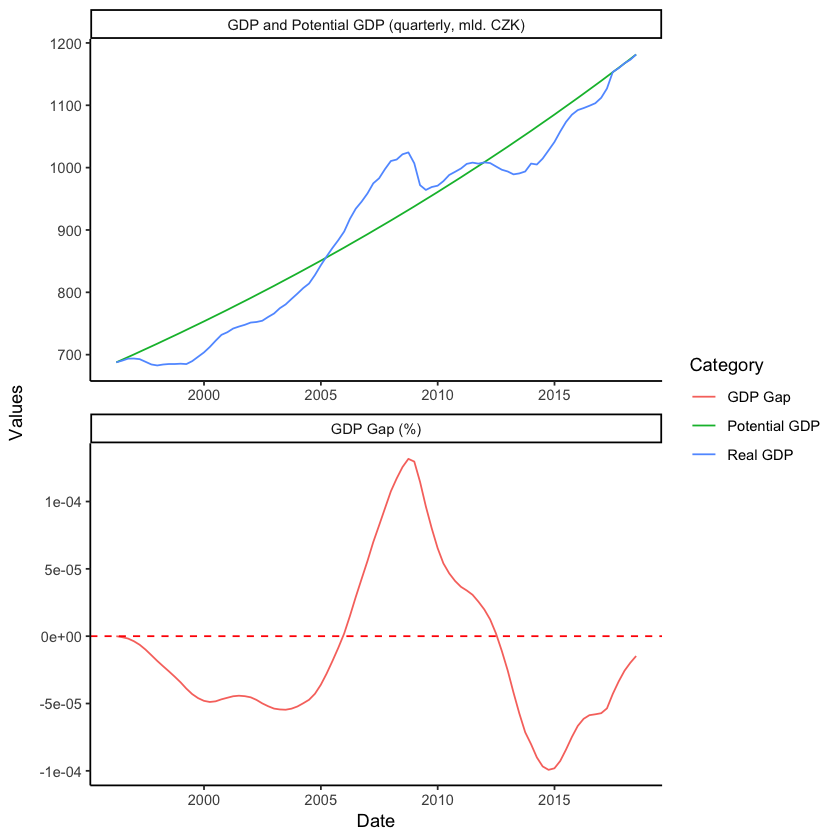

In [15]:
data.plot = data.frame(Date     = rep(dates,3),
                       Category = rep(c("Real GDP","Potential GDP","GDP Gap"), each=pers),
                       Plottt   = c(rep("GDP and Potential GDP (quarterly, mld. CZK)",2*pers), rep("GDP Gap (%)",pers)),
                       Values   = c(exp(gdp),exp(statesF1[,1]),statesF1[,2]*100))

ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                              geom_line(aes(color=Category)) + 
               facet_wrap(~ Plottt, ncol = 1, scales='free') +
                                             theme_classic() + 
  geom_hline(aes(yintercept=int), data.frame(int=c(0),Plottt=c("GDP Gap (%)")), color="red",lty=2)

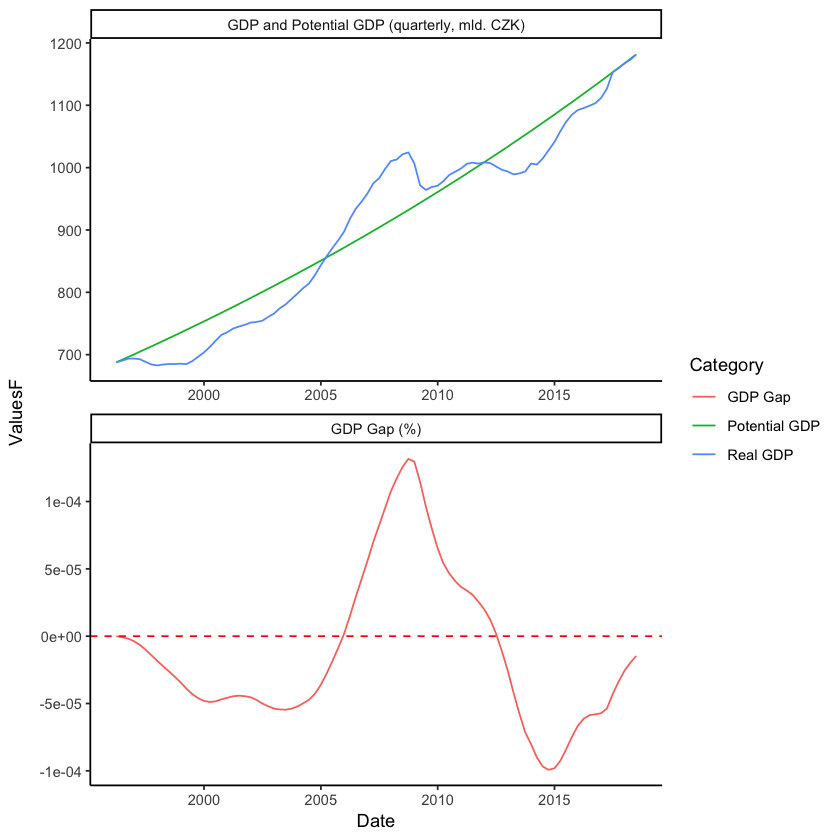

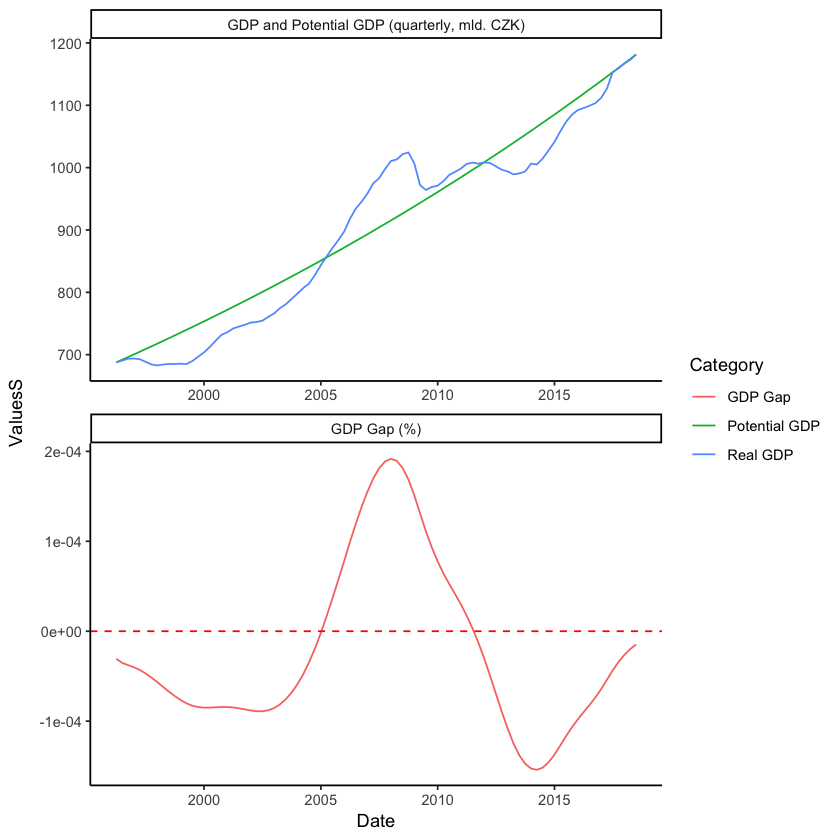

In [16]:
# this does the same with tools from package MASS
library("MASS")
statesS         = matrix(NA,nrow = pers, ncol = 3)
statesS[pers,]  = statesF1[pers,]
stVarsS         = array(NA,dim = c(pers,3,3))
stVarsS[pers,,] = stVarsF1[pers,,]

#for loop
for (tt in seq(from  = pers-1, to = 1, by = -1)){
            VV  = stVarsF1[tt,,] %*% t(FF) %*% ginv(stVarsF1[tt+1,,])
  statesS[tt,]  = statesF1[tt,]  + VV%*%(statesS[tt+1,] - statesF0[tt+1,])
  stVarsS[tt,,] = stVarsF1[tt,,] + VV%*%(stVarsS[tt+1,,]- stVarsF0[tt+1,,])%*%t(VV)
}

#plotting
data.plot = data.frame(Date     = rep(dates,3),
                       Category = rep(c("Real GDP","Potential GDP","GDP Gap"), each=pers),
                       Plottt   = c(rep("GDP and Potential GDP (quarterly, mld. CZK)",2*pers), rep("GDP Gap (%)",pers)),
                       ValuesF  = c(exp(gdp),exp(statesF1[,1]),statesF1[,2]*100),
                       ValuesS  = c(exp(gdp),exp(statesS[,1]),statesS[,2]*100))

ggplot(data=data.plot,aes(x=Date, y=ValuesF, group=Category)) +
                               geom_line(aes(color=Category)) + 
                facet_wrap(~ Plottt, ncol = 1, scales='free') + 
                                              theme_classic() + 
  geom_hline(aes(yintercept=int), data.frame(int=c(0),Plottt=c("GDP Gap (%)")), color="red",lty=2)

ggplot(data=data.plot,aes(x=Date, y=ValuesS, group=Category)) +
                               geom_line(aes(color=Category)) + 
                facet_wrap(~ Plottt, ncol = 1, scales='free') + 
                                              theme_classic() + 
  geom_hline(aes(yintercept=int), data.frame(int=c(0),Plottt=c("GDP Gap (%)")), color="red",lty=2)



## Model 2: With MLE

HEADER

In [17]:

# BCT Winter 2018
# November 14, 2018
# STATE-SPACE MODELS AND KALMAN FILTER

# FULL TREND-CYCLE WITH ESTIMATION



Setting up variables

In [18]:
#### HOUSEKEEPING ####
rm(list = ls())

#### DATA ####
library(readxl)
gdp   <- na.omit(read_excel("gdpCZ.xlsx"))
dates <- gdp$period
gdp   <- log(gdp$value)
gdpG  <- c(0,diff(gdp))

PLotting

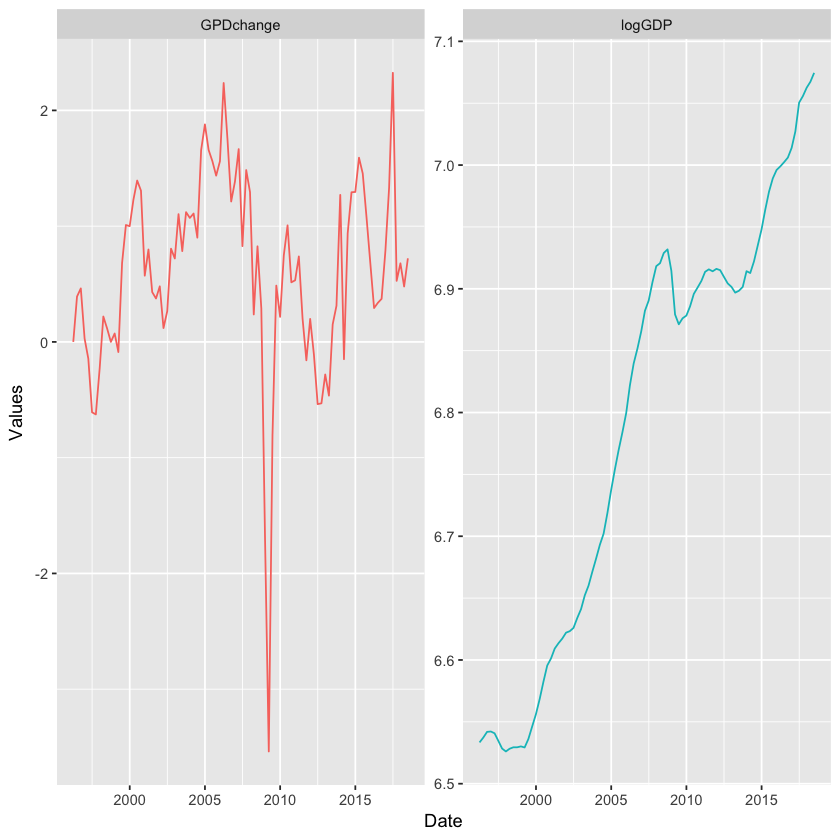

In [19]:
# Prepare nice ggplot #
library(ggplot2)
data.plot = data.frame(Date = rep(dates,2),
                       Category = rep(c("logGDP","GPDchange"), each=length(gdp)),
                       Values = c(gdp,gdpG*100))

ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                              geom_line(aes(color=Category)) + 
                       facet_wrap(~ Category, scales='free') + 
                               theme(legend.position="none")

In [20]:

#### STORY ####
# some of the dynamics is driven by potential GDP, some by some cyclical fluctuations (GDP gap)
# we are interested in the potential, which is, however, unobservable
# consequently, we will try to estimate the potential as a state variable in the state-space model

#### MACRO-MODELLING ####

# SPACE of models --> model selection --> parameter estimation

# ARIMA models ... I have a small SPACE of possible models defined by the AR/MA/D orders
#                  the only structure imposed is that the residuals are white noise
#                  otherwise all is data-driven (ACF/PACF, residual diagnostics, ...)
# State space model ... infinitelly large structure of possible models
#                       the models are defined by the set of 


#### MODEL ####


# 1) MEASUREMENT EQUATION:  

#   y(t)   =     H       *    X(t)      + v(t);   v(t) ~ N(0,R)  
#
#   gpd    =  transformation of states  + measurement error
#
#                          |TREND(t)  |
#   y(t)   =  [h1 h2 h3] * |CYCLE(t)  | + v(t);   v(t) ~ N(0,sigmaR)  
#                          |CYCLE(t-1)|


# 2) TRANSITION EQUATION:  

#     X(t)    =      A   +        F        *     X(t-1)     +    u(t);  u(t) ~ N(0,Q)  

# |TREND(t)  |     |a1|     |f11 f12 f13|     |TREND(t-1)|     |u1(t)|             |sigmaQ1 0 0|
# |CYCLE(t)  |  =  |a2|  +  |f21 f22 f23|  *  |CYCLE(t-1)|  +  |u2(t)|; u(t) ~ N(0,|0 sigmaQ2 0|)  
# |CYCLE(t-1)|     |a3|     |f21 f22 f33|     |CYCLE(t-2)|     |u3(t)|;            |0 0 sigmaQ3|  

#   factors   =    some dynamic process                     +  transition (state) error


# 3) RESTRICTIONS - to identify the model:

# if not, infinity of equivalent models exist:
#     - states fluctuating around 1000 and H parameters of a degree 0.01
#     - states fluctuating around  100 and H parameters of a degree 0.10
#     - states fluctuating around   10 and H parameters of a degree 1.00
#     - etc.
# => estimation would not converge!!

# restrictions on measurement equation:
# - h1 = 1, h2 = 1, h3 = 0
# - R is zero

# restrictions on transition equation:
# - trend equation:        f11 = 1, f12 = f13 = 0 
# - cycle equation:        f21 = 0
# - lagged cycle identity: f32 = 1, f31 = f33 = a3 = 0
# - Q is diagonal

# restriction on the relation u and v:
# u(t) and v(t) have zero covariance

#####################################################################################3

The only difference here is that the variables are placed inside theta vector and later recalled from theta vector.

In [21]:
a1      = mean(diff(gdp)) 
a2      = 0
sigmaQ1 = log(sd(diff(gdp))^2)  
sigmaQ2 = log(sd(diff(gdp))^2)  
f22in   = 2  
f23in   = 2  
 
theta = c(a1, a2, sigmaQ1, sigmaQ2, f22in, f23in)
 
data   = gdp
pers  <- length(data)

In [22]:
#the same

In [23]:
HH = matrix(c(1, 1, 0), ncol = 3)
AA = matrix(c(theta[1:2],0), ncol = 1)
RR = 0
 
QQ = diag(c(exp(theta[3:4]),0))

In [24]:
#same

In [25]:
f22ad = theta[5]/(1+abs(theta[5]))
f23ad = theta[6]/(1+abs(theta[6]))
f22   = f22ad + f23ad
f23   = -f22ad*f23ad
FF    = matrix(c( 1 , 0 , 0 ,
                  0 ,f22,f23,
                  0 , 1 , 0),byrow = T, ncol = 3)

In [26]:
#same

In [27]:
X0 = c(data[1]-theta[1],0,0)  
P0 = 10*QQ      

states0 = matrix(NA,nrow = pers, ncol = 3)
states1 = matrix(NA,nrow = pers, ncol = 3)

stVars0 = array(NA,dim = c(pers,3,3))
stVars1 = array(NA,dim = c(pers,3,3))

In [28]:
#same

In [29]:
for (tt in 1:pers){
 
  X1pred = AA + FF%*%X0           
  P1pred = FF%*%P0%*%t(FF) + QQ    
  YYpred = HH%*%X1pred            
  
  states0[tt,]  = X1pred
  stVars0[tt,,] = P1pred
  
  YYerror = data[tt] - YYpred      
  
  obsVAR = HH%*%P1pred%*%t(HH) + RR       
  KG     = P1pred%*%t(HH)%*%(solve(obsVAR)^(-1)) 
  X1     = X1pred + KG%*%YYerror         
  P1     = P1pred - KG%*%HH%*%P1pred       
 
  states1[tt,] = X1
  stVars1[tt,,] = P1
  
  X0 = X1
  P0 = P1
}

In [30]:
#same- plot

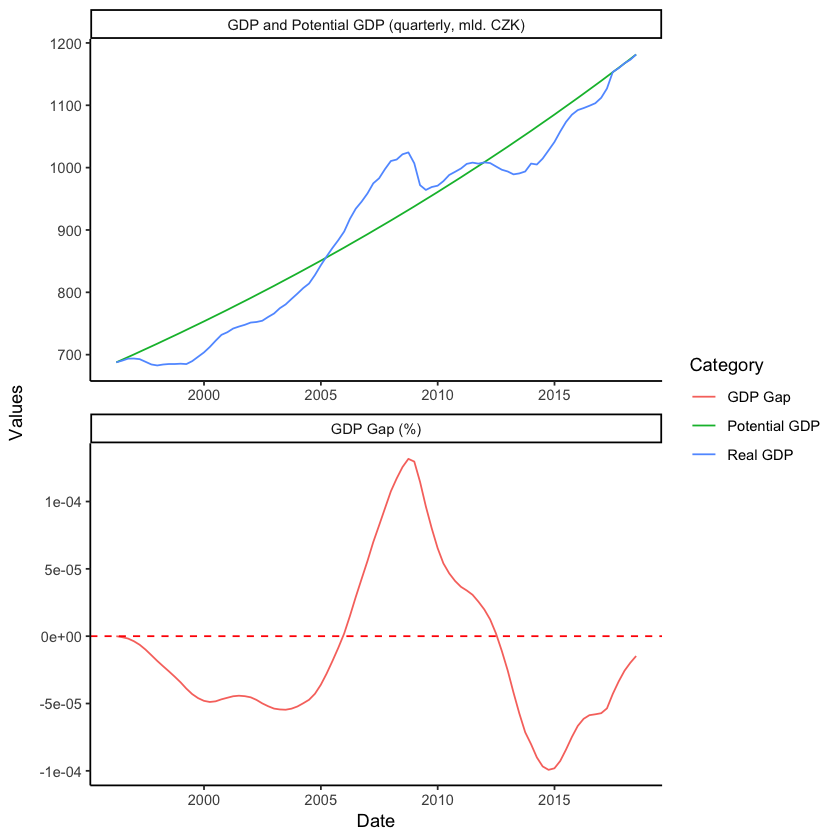

In [31]:
data.plot = data.frame(Date = rep(dates,3),
                       Category = rep(c("Real GDP","Potential GDP","GDP Gap"), each=pers),
                       Plottt = c(rep("GDP and Potential GDP (quarterly, mld. CZK)",2*pers),rep("GDP Gap (%)",pers)),
                       Values = c(exp(gdp),exp(states1[,1]),states1[,2]*100))

ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                              geom_line(aes(color=Category)) + 
               facet_wrap(~ Plottt, ncol = 1, scales='free') +
                                             theme_classic() + 
  geom_hline(aes(yintercept=int), data.frame(int=c(0),Plottt=c("GDP Gap (%)")), color="red",lty=2)



In [32]:
#introduction of new function kalmanFUN

In [38]:
kalmanFUN <- function(theta, data, type){

  pers  <- length(data)
  
  HH = matrix(c(1, 1, 0), ncol = 3)
  AA = matrix(c(theta[1:2],0), ncol = 1)
  RR = 0
  QQ = diag(c(exp(theta[3:4]),0))
  
  f22ad = theta[5]/(1+abs(theta[5]))
  f23ad = theta[6]/(1+abs(theta[6]))
  f22   = f22ad + f23ad
  f23   = -f22ad*f23ad
  FF    = matrix(c( 1 , 0 , 0 ,
                 0 ,f22,f23,
                 0 , 1 , 0),byrow = T, ncol = 3)
  
  X0 = c(data[1]-theta[1],0,0)  
  P0 = 10*QQ              
  
  states0 = matrix(NA,nrow = pers, ncol = 3)
  states1 = matrix(NA,nrow = pers, ncol = 3)
  
  stVars0 = array(NA,dim = c(pers,3,3))
  stVars1 = array(NA,dim = c(pers,3,3))   #until here it copies the structure of previous code
  
  loglk = 0
  
  for (tt in 1:pers){ #for loop with if condition that 
    
    X1pred = AA + FF%*%X0            
    P1pred = FF%*%P0%*%t(FF) + QQ 
    YYpred = HH%*%X1pred             
    
    states0[tt,] = X1pred
    stVars0[tt,,] = P1pred
    
    YYerror = data[tt] - YYpred         
    obsVAR = HH%*%P1pred%*%t(HH) + RR   
    
    if (rcond(obsVAR) > 1e-10){    #if some value is larger than 1e-10, it assigns log likelihood = to formula, else it's decreased by 1e50
      loglk = loglk - 1/2*(log(2*pi) + log(det(obsVAR)) + t(YYerror) %*% solve(obsVAR) %*% YYerror) #see slide 14
    }else{  
      loglk = loglk - 1e50
      break
    }
    
    KG     = P1pred%*%t(HH)%*%(solve(obsVAR)^(-1))  
    X1     = X1pred + KG%*%YYerror                  
    P1     = P1pred - KG%*%HH%*%P1pred            
    
    states1[tt,]  = X1
    stVars1[tt,,] = P1
    
    X0 = X1 #reseting the states
    P0 = P1
  }

  negLogLik = -loglk
   
  if (type == "MLE"){ #if MLE then return negative log likelihood, else  output a list of states
    return(negLogLik) 
  } else {
    output = list()
    output$states0 = states0
    output$states1 = states1
    output$stVars0 = stVars0
    output$stVars1 = stVars1
    output$FF = FF
    return(output)
  }
}



In [34]:
library("MASS")
kalmanSMTH <- function(output){

  states0 = output$states0
  states1 = output$states1
  stVars0 = output$stVars0
  stVars1 = output$stVars1
  
  FF = output$FF
  
  pers = dim(states0)[1]
  
  statesSmooth         = matrix(NA,nrow = pers, ncol = 3)
  statesSmooth[pers,]  = states1[pers,]
  stVarsSmooth         = array(NA,dim = c(pers,3,3))
  stVarsSmooth[pers,,] = stVars1[pers,,]
  
  for (tt in seq(from  = pers-1, to = 1, by = -1)){
                   VV  = stVars1[tt,,] %*% t(FF) %*% ginv(stVars1[tt+1,,])
    statesSmooth[tt,]  = states1[tt,]  + VV%*%(statesSmooth[tt+1,] -states0[tt+1,])
    stVarsSmooth[tt,,] = stVars1[tt,,] + VV%*%(stVarsSmooth[tt+1,,]-stVars0[tt+1,,])%*%t(VV)
  }
  return(statesSmooth)
}

In [39]:
kalmanFUN(theta, gdp, "MLE") #this uses the function we described earlier
outInit <- kalmanFUN(theta, gdp, "X")  
statesF <- outInit$states1
statesS <- kalmanSMTH(outInit)

-135.141


Plotting the data

  Nelder-Mead direct search function minimizer
function value for initial parameters = -135.140963
  Scaled convergence tolerance is 2.01376e-06
Stepsize computed as 0.955058
BUILD              7 18685797.395623 -135.140963
LO-REDUCTION       9 2921206.110163 -135.140963
HI-REDUCTION      11 769379.062881 -135.140963
HI-REDUCTION      13 667697.620829 -135.140963
HI-REDUCTION      15 151580.882452 -135.140963
HI-REDUCTION      17 149492.167193 -135.140963
HI-REDUCTION      19 35016.420957 -135.140963
HI-REDUCTION      21 30812.712813 -135.140963
HI-REDUCTION      23 7754.176344 -135.140963
HI-REDUCTION      25 7201.094636 -135.140963
HI-REDUCTION      27 1826.029410 -135.140963
LO-REDUCTION      29 1700.363716 -135.140963
LO-REDUCTION      31 348.809824 -135.140963
HI-REDUCTION      33 170.550509 -135.140963
HI-REDUCTION      35 -44.996563 -135.140963
HI-REDUCTION      37 -73.009086 -135.140963
HI-REDUCTION      39 -113.415557 -135.140963
REFLECTION        41 -124.158868 -148.138994
HI

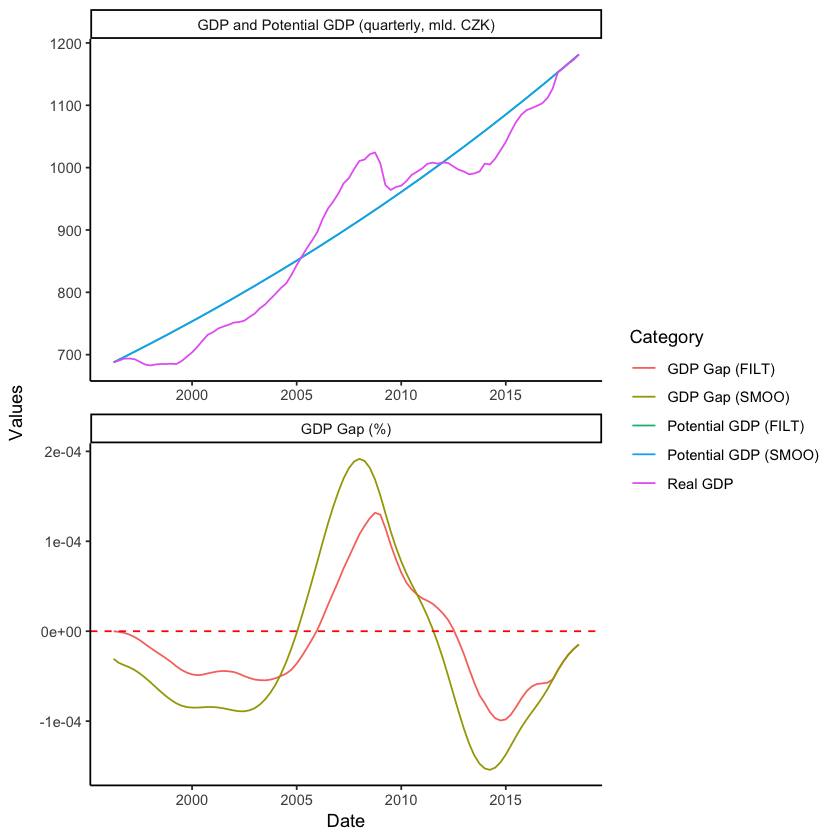

In [41]:
data.plot = data.frame(
  Date     = rep(dates,5),
  Category = rep(c("Real GDP",
                   "Potential GDP (FILT)",
                   "GDP Gap (FILT)",
                   "Potential GDP (SMOO)",
                   "GDP Gap (SMOO)"),each=pers),
  Plottt   = rep(c("GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)"),each=pers),
  Values = c(exp(gdp),
             exp(statesF[,1]),
             statesF[,2]*100,
             exp(statesS[,1]),
             statesS[,2]*100)
)
ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                              geom_line(aes(color=Category)) + 
               facet_wrap(~ Plottt, ncol = 1, scales='free') + 
                                             theme_classic() + 
  geom_hline(aes(yintercept=int), data.frame(int=c(0),Plottt=c("GDP Gap (%)")), color="red",lty=2)

parOpt <- optim(theta, kalmanFUN, gr = NULL, gdp, "MLE", control = list(trace = 3, maxit = 5000), 
                method = "Nelder-Mead")

In [42]:
thetaO = parOpt$par

print(theta)
print(thetaO)

[1]  0.006080757  0.000000000 -9.550580655 -9.550580655  2.000000000
[6]  2.000000000
[1]   0.007023967  -0.005399277 -10.262355476 -40.739899026   2.278885855
[6]   2.278003769


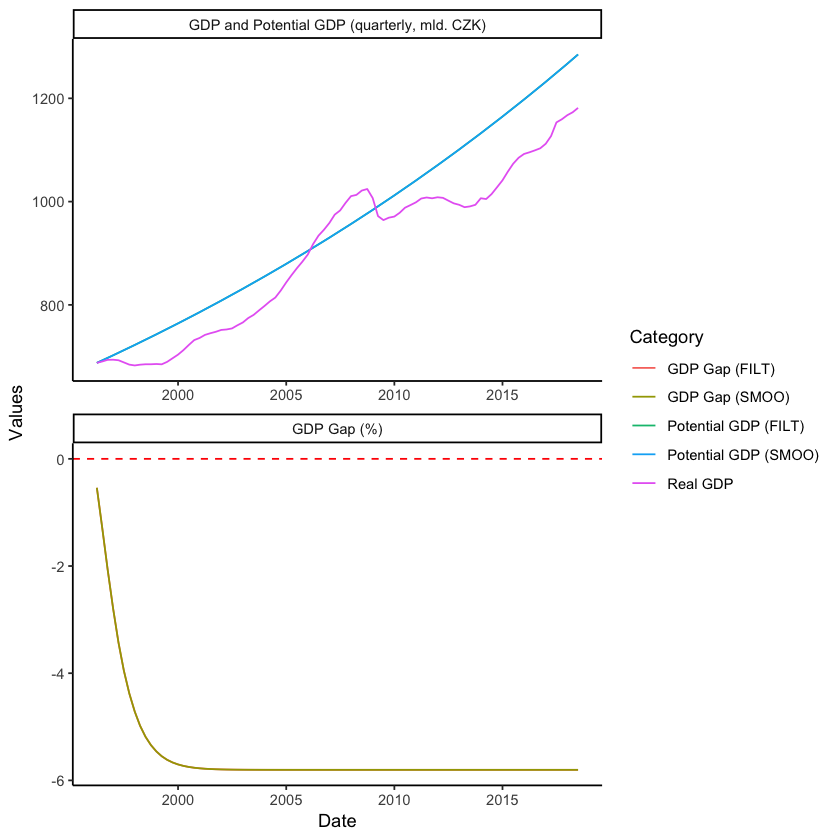

In [45]:


outFin     <- kalmanFUN(thetaO, gdp, "X")  
statesFinF <- outFin$states1
statesFinS <- kalmanSMTH(outFin)

data.plot  = data.frame(
  Date     = rep(dates,5),
  Category = rep(c("Real GDP",
                   "Potential GDP (FILT)",
                   "GDP Gap (FILT)",
                   "Potential GDP (SMOO)",
                   "GDP Gap (SMOO)"),each=pers),
  Plottt   = rep(c("GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)"),each=pers),
  Values = c(exp(gdp),
             exp(statesFinF[,1]),
             statesFinF[,2]*100,
             exp(statesFinS[,1]),
             statesFinS[,2]*100)
)

ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                              geom_line(aes(color=Category)) + 
               facet_wrap(~ Plottt, ncol = 1, scales='free') + 
                                             theme_classic() + 
  geom_hline(aes(yintercept=int), data.frame(int=c(0),Plottt=c("GDP Gap (%)")), color="red",lty=2)

HH = matrix(c(1, 1, 0), ncol = 3)
AA = matrix(c(thetaO[1:2],0), ncol = 1)
RR = 0
QQ = diag(c(exp(thetaO[3:4]),0))

f22ad = thetaO[5]/(1+abs(thetaO[5]))
f23ad = thetaO[6]/(1+abs(thetaO[6]))
f22   = f22ad + f23ad
f23   = -f22ad*f23ad
FF    = matrix(c( 1 , 0 , 0 ,
                  0 ,f22,f23,
                  0 , 1 , 0),byrow = T, ncol = 3)


## 2. Using the code with MLE estimation, adjust the parameters R (measurement error variance) and Q (variances of the trend and the cycle) in the code. Show results for their various combinations:

in case R is significantly higher than both diagonal elements of Q

in case R is significantly smaller than both diagonal elements of Q

in case R is equal to both diagonal elements of Q / to their sum

various combinations of relations between the variance of trend and cycle (the Q matrix diagonal elements)

Explain the varying results in estimated trends using the knowledge about how the Kalman filter procedure uses information about R and Q.

### The first two options produced very similar-looking graphs. The third option ended up causing an error "non-conformable arguments". Code bellow. ###

## in case R is significantly higher than both elements of Q

Warning message:
“Removed 170 rows containing missing values (geom_path).”

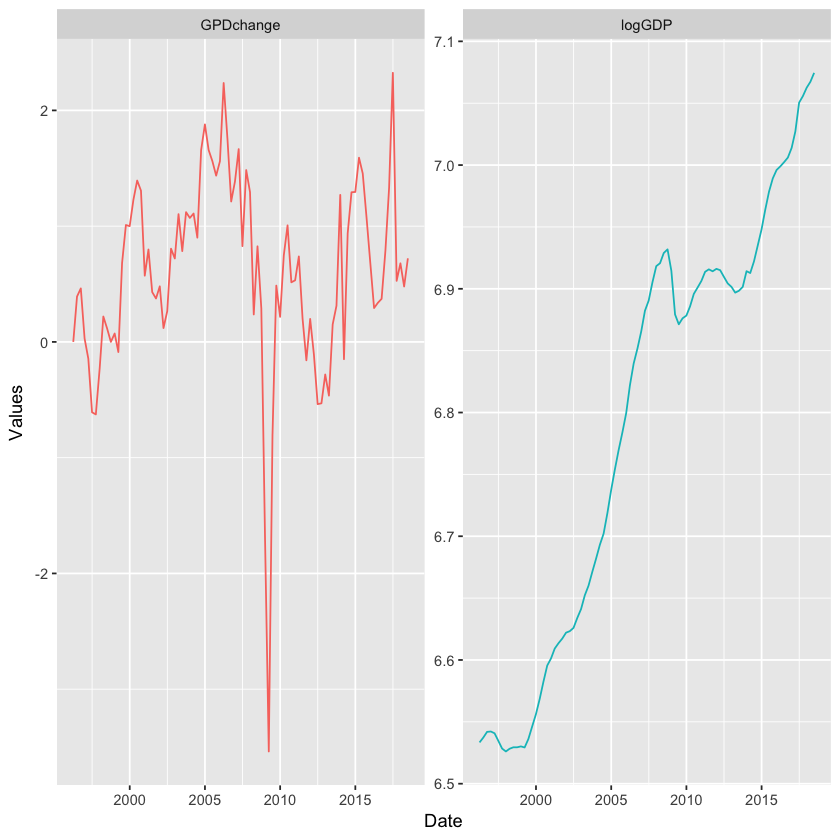

Warning message in log(det(obsVAR)):
“NaNs produced”Warning message in log(det(obsVAR)):
“NaNs produced”

ERROR: Error in if (rcond(obsVAR) > 1e-10) {: missing value where TRUE/FALSE needed


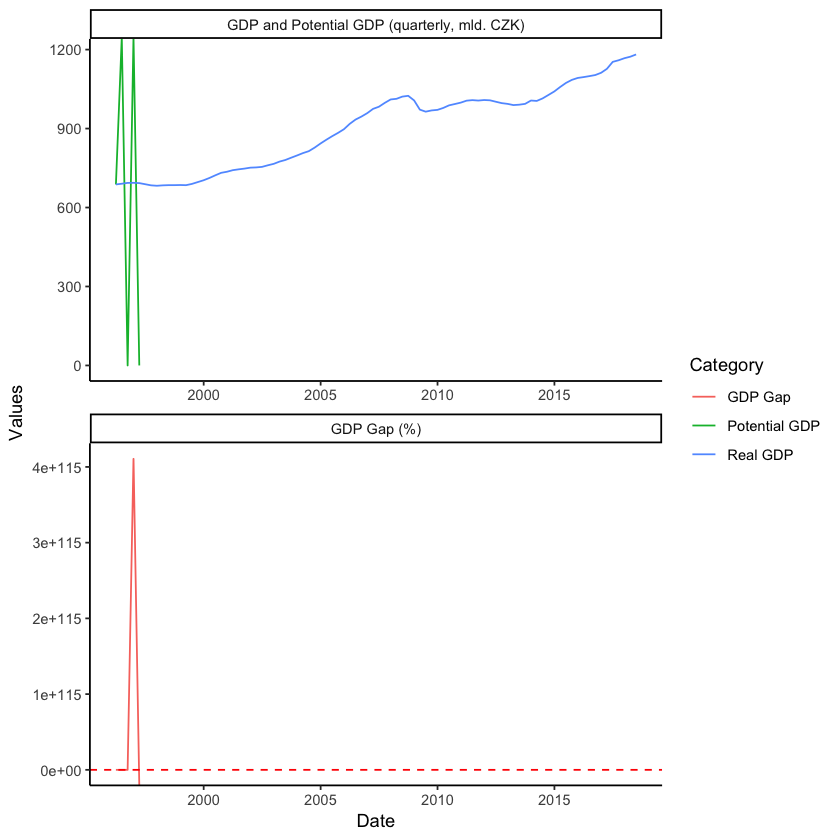

In [54]:
# BCT Winter 2018
# November 14, 2018
# STATE-SPACE MODELS AND KALMAN FILTER

# FULL TREND-CYCLE WITH ESTIMATION

#### HOUSEKEEPING ####
rm(list = ls())

#### DATA ####
library(readxl)
gdp   <- na.omit(read_excel("gdpCZ.xlsx"))
dates <- gdp$period
gdp   <- log(gdp$value)
gdpG  <- c(0,diff(gdp))

# Prepare nice ggplot #
library(ggplot2)
data.plot = data.frame(Date = rep(dates,2),
                       Category = rep(c("logGDP","GPDchange"), each=length(gdp)),
                       Values = c(gdp,gdpG*100))

ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                              geom_line(aes(color=Category)) + 
                       facet_wrap(~ Category, scales='free') + 
                               theme(legend.position="none")
#### STORY ####
# some of the dynamics is driven by potential GDP, some by some cyclical fluctuations (GDP gap)
# we are interested in the potential, which is, however, unobservable
# consequently, we will try to estimate the potential as a state variable in the state-space model

#### MACRO-MODELLING ####

# SPACE of models --> model selection --> parameter estimation

# ARIMA models ... I have a small SPACE of possible models defined by the AR/MA/D orders
#                  the only structure imposed is that the residuals are white noise
#                  otherwise all is data-driven (ACF/PACF, residual diagnostics, ...)
# State space model ... infinitelly large structure of possible models
#                       the models are defined by the set of 


#### MODEL ####


# 1) MEASUREMENT EQUATION:  

#   y(t)   =     H       *    X(t)      + v(t);   v(t) ~ N(0,R)  
#
#   gpd    =  transformation of states  + measurement error
#
#                          |TREND(t)  |
#   y(t)   =  [h1 h2 h3] * |CYCLE(t)  | + v(t);   v(t) ~ N(0,sigmaR)  
#                          |CYCLE(t-1)|


# 2) TRANSITION EQUATION:  

#     X(t)    =      A   +        F        *     X(t-1)     +    u(t);  u(t) ~ N(0,Q)  

# |TREND(t)  |     |a1|     |f11 f12 f13|     |TREND(t-1)|     |u1(t)|             |sigmaQ1 0 0|
# |CYCLE(t)  |  =  |a2|  +  |f21 f22 f23|  *  |CYCLE(t-1)|  +  |u2(t)|; u(t) ~ N(0,|0 sigmaQ2 0|)  
# |CYCLE(t-1)|     |a3|     |f21 f22 f33|     |CYCLE(t-2)|     |u3(t)|;            |0 0 sigmaQ3|  

#   factors   =    some dynamic process                     +  transition (state) error


# 3) RESTRICTIONS - to identify the model:

# if not, infinity of equivalent models exist:
#     - states fluctuating around 1000 and H parameters of a degree 0.01
#     - states fluctuating around  100 and H parameters of a degree 0.10
#     - states fluctuating around   10 and H parameters of a degree 1.00
#     - etc.
# => estimation would not converge!!

# restrictions on measurement equation:
# - h1 = 1, h2 = 1, h3 = 0
# - R is zero

# restrictions on transition equation:
# - trend equation:        f11 = 1, f12 = f13 = 0 
# - cycle equation:        f21 = 0
# - lagged cycle identity: f32 = 1, f31 = f33 = a3 = 0
# - Q is diagonal

# restriction on the relation u and v:
# u(t) and v(t) have zero covariance

#####################################################################################3

a1      = mean(diff(gdp)) 
a2      = 0
sigmaQ1 = log(sd(diff(gdp))^2)  
sigmaQ2 = log(sd(diff(gdp))^2)  
f22in   = 2  
f23in   = 2  
 
theta = c(a1, a2, sigmaQ1, sigmaQ2, f22in, f23in)
 
data   = gdp
pers  <- length(data)
 
HH = matrix(c(1, 1, 0), ncol = 3)
AA = matrix(c(theta[1:2],0), ncol = 1)
RR = 100000000
 
QQ = diag(c(exp(theta[3:4]),0))

f22ad = theta[5]/(1+abs(theta[5]))
f23ad = theta[6]/(1+abs(theta[6]))
f22   = f22ad + f23ad
f23   = -f22ad*f23ad
FF    = matrix(c( 1 , 0 , 0 ,
                  0 ,f22,f23,
                  0 , 1 , 0),byrow = T, ncol = 3)

X0 = c(data[1]-theta[1],0,0)  
P0 = 10*QQ      

states0 = matrix(NA,nrow = pers, ncol = 3)
states1 = matrix(NA,nrow = pers, ncol = 3)

stVars0 = array(NA,dim = c(pers,3,3))
stVars1 = array(NA,dim = c(pers,3,3))

for (tt in 1:pers){
 
  X1pred = AA + FF%*%X0           
  P1pred = FF%*%P0%*%t(FF) + QQ    
  YYpred = HH%*%X1pred            
  
  states0[tt,]  = X1pred
  stVars0[tt,,] = P1pred
  
  YYerror = data[tt] - YYpred      
  
  obsVAR = HH%*%P1pred%*%t(HH) + RR       
  KG     = P1pred%*%t(HH)%*%(solve(obsVAR)^(-1)) 
  X1     = X1pred + KG%*%YYerror         
  P1     = P1pred - KG%*%HH%*%P1pred       
 
  states1[tt,] = X1
  stVars1[tt,,] = P1
  
  X0 = X1
  P0 = P1
}

data.plot = data.frame(Date = rep(dates,3),
                       Category = rep(c("Real GDP","Potential GDP","GDP Gap"), each=pers),
                       Plottt = c(rep("GDP and Potential GDP (quarterly, mld. CZK)",2*pers),rep("GDP Gap (%)",pers)),
                       Values = c(exp(gdp),exp(states1[,1]),states1[,2]*100))

ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                              geom_line(aes(color=Category)) + 
               facet_wrap(~ Plottt, ncol = 1, scales='free') +
                                             theme_classic() + 
  geom_hline(aes(yintercept=int), data.frame(int=c(0),Plottt=c("GDP Gap (%)")), color="red",lty=2)

kalmanFUN <- function(theta, data, type){

  pers  <- length(data)
  
  HH = matrix(c(1, 1, 0), ncol = 3)
  AA = matrix(c(theta[1:2],0), ncol = 1)
  RR = 100000000
  QQ = diag(c(exp(theta[3:4]),0))
  
  f22ad = theta[5]/(1+abs(theta[5]))
  f23ad = theta[6]/(1+abs(theta[6]))
  f22   = f22ad + f23ad
  f23   = -f22ad*f23ad
  FF    = matrix(c( 1 , 0 , 0 ,
                 0 ,f22,f23,
                 0 , 1 , 0),byrow = T, ncol = 3)
  
  X0 = c(data[1]-theta[1],0,0)  
  P0 = 10*QQ              
  
  states0 = matrix(NA,nrow = pers, ncol = 3)
  states1 = matrix(NA,nrow = pers, ncol = 3)
  
  stVars0 = array(NA,dim = c(pers,3,3))
  stVars1 = array(NA,dim = c(pers,3,3))
  
  loglk = 0
  
  for (tt in 1:pers){
    
    X1pred = AA + FF%*%X0            
    P1pred = FF%*%P0%*%t(FF) + QQ 
    YYpred = HH%*%X1pred             
    
    states0[tt,] = X1pred
    stVars0[tt,,] = P1pred
    
    YYerror = data[tt] - YYpred         
    obsVAR = HH%*%P1pred%*%t(HH) + RR   
    
    if (rcond(obsVAR) > 1e-10){
      loglk = loglk - 1/2*(log(2*pi) + log(det(obsVAR)) + t(YYerror) %*% solve(obsVAR) %*% YYerror) #see slide 14
    }else{  
      loglk = loglk - 1e50
      break
    }
    
    KG     = P1pred%*%t(HH)%*%(solve(obsVAR)^(-1))  
    X1     = X1pred + KG%*%YYerror                  
    P1     = P1pred - KG%*%HH%*%P1pred            
    
    states1[tt,]  = X1
    stVars1[tt,,] = P1
    
    X0 = X1
    P0 = P1
  }

  negLogLik = -loglk
   
  if (type == "MLE"){
    return(negLogLik) 
  } else {
    output = list()
    output$states0 = states0
    output$states1 = states1
    output$stVars0 = stVars0
    output$stVars1 = stVars1
    output$FF = FF
    return(output)
  }
}

library("MASS")
kalmanSMTH <- function(output){

  states0 = output$states0
  states1 = output$states1
  stVars0 = output$stVars0
  stVars1 = output$stVars1
  
  FF = output$FF
  
  pers = dim(states0)[1]
  
  statesSmooth         = matrix(NA,nrow = pers, ncol = 3)
  statesSmooth[pers,]  = states1[pers,]
  stVarsSmooth         = array(NA,dim = c(pers,3,3))
  stVarsSmooth[pers,,] = stVars1[pers,,]
  
  for (tt in seq(from  = pers-1, to = 1, by = -1)){
                   VV  = stVars1[tt,,] %*% t(FF) %*% ginv(stVars1[tt+1,,])
    statesSmooth[tt,]  = states1[tt,]  + VV%*%(statesSmooth[tt+1,] -states0[tt+1,])
    stVarsSmooth[tt,,] = stVars1[tt,,] + VV%*%(stVarsSmooth[tt+1,,]-stVars0[tt+1,,])%*%t(VV)
  }
  return(statesSmooth)
}

kalmanFUN(theta, gdp, "MLE")          
outInit <- kalmanFUN(theta, gdp, "X")  
statesF <- outInit$states1
statesS <- kalmanSMTH(outInit)

data.plot = data.frame(
  Date     = rep(dates,5),
  Category = rep(c("Real GDP",
                   "Potential GDP (FILT)",
                   "GDP Gap (FILT)",
                   "Potential GDP (SMOO)",
                   "GDP Gap (SMOO)"),each=pers),
  Plottt   = rep(c("GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)"),each=pers),
  Values = c(exp(gdp),
             exp(statesF[,1]),
             statesF[,2]*100,
             exp(statesS[,1]),
             statesS[,2]*100)
)

ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                              geom_line(aes(color=Category)) + 
               facet_wrap(~ Plottt, ncol = 1, scales='free') + 
                                             theme_classic() + 
  geom_hline(aes(yintercept=int), data.frame(int=c(0),Plottt=c("GDP Gap (%)")), color="red",lty=2)

parOpt <- optim(theta, kalmanFUN, gr = NULL, gdp, "MLE", control = list(trace = 3, maxit = 5000), 
                method = "Nelder-Mead")

thetaO = parOpt$par

print(theta)
print(thetaO)

outFin     <- kalmanFUN(thetaO, gdp, "X")  
statesFinF <- outFin$states1
statesFinS <- kalmanSMTH(outFin)

data.plot  = data.frame(
  Date     = rep(dates,5),
  Category = rep(c("Real GDP",
                   "Potential GDP (FILT)",
                   "GDP Gap (FILT)",
                   "Potential GDP (SMOO)",
                   "GDP Gap (SMOO)"),each=pers),
  Plottt   = rep(c("GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)"),each=pers),
  Values = c(exp(gdp),
             exp(statesFinF[,1]),
             statesFinF[,2]*100,
             exp(statesFinS[,1]),
             statesFinS[,2]*100)
)

ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                              geom_line(aes(color=Category)) + 
               facet_wrap(~ Plottt, ncol = 1, scales='free') + 
                                             theme_classic() + 
  geom_hline(aes(yintercept=int), data.frame(int=c(0),Plottt=c("GDP Gap (%)")), color="red",lty=2)

HH = matrix(c(1, 1, 0), ncol = 3)
AA = matrix(c(thetaO[1:2],0), ncol = 1)
RR = 100000000
QQ = diag(c(exp(thetaO[3:4]),0))

f22ad = thetaO[5]/(1+abs(thetaO[5]))
f23ad = thetaO[6]/(1+abs(thetaO[6]))
f22   = f22ad + f23ad
f23   = -f22ad*f23ad
FF    = matrix(c( 1 , 0 , 0 ,
                  0 ,f22,f23,
                  0 , 1 , 0),byrow = T, ncol = 3)




## in case R is significantly smaller than both elements of Q

Warning message:
“Removed 172 rows containing missing values (geom_path).”

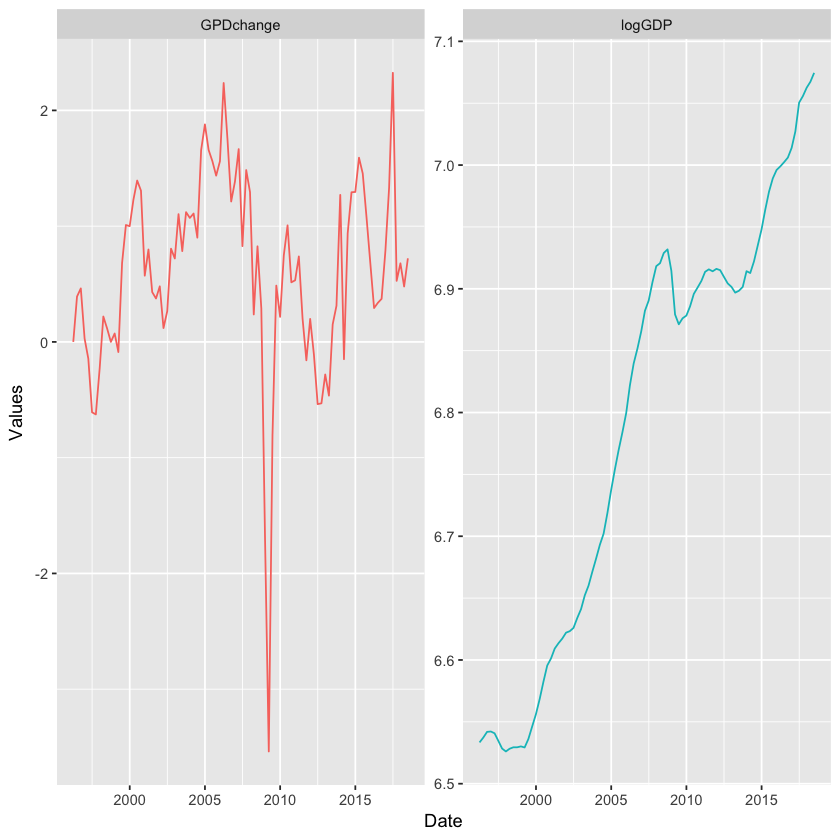

Warning message in log(det(obsVAR)):
“NaNs produced”Warning message in log(det(obsVAR)):
“NaNs produced”

ERROR: Error in if (rcond(obsVAR) > 1e-10) {: missing value where TRUE/FALSE needed


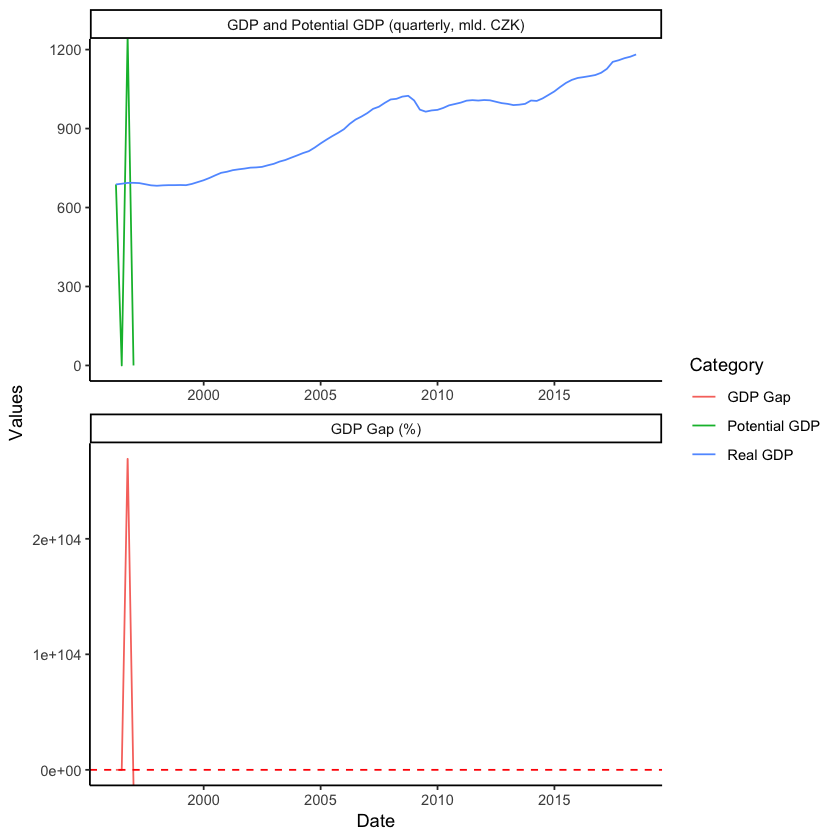

In [60]:
# BCT Winter 2018
# November 14, 2018
# STATE-SPACE MODELS AND KALMAN FILTER

# FULL TREND-CYCLE WITH ESTIMATION

#### HOUSEKEEPING ####
rm(list = ls())

#### DATA ####
library(readxl)
gdp   <- na.omit(read_excel("gdpCZ.xlsx"))
dates <- gdp$period
gdp   <- log(gdp$value)
gdpG  <- c(0,diff(gdp))

# Prepare nice ggplot #
library(ggplot2)
data.plot = data.frame(Date = rep(dates,2),
                       Category = rep(c("logGDP","GPDchange"), each=length(gdp)),
                       Values = c(gdp,gdpG*100))

ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                              geom_line(aes(color=Category)) + 
                       facet_wrap(~ Category, scales='free') + 
                               theme(legend.position="none")
#### STORY ####
# some of the dynamics is driven by potential GDP, some by some cyclical fluctuations (GDP gap)
# we are interested in the potential, which is, however, unobservable
# consequently, we will try to estimate the potential as a state variable in the state-space model

#### MACRO-MODELLING ####

# SPACE of models --> model selection --> parameter estimation

# ARIMA models ... I have a small SPACE of possible models defined by the AR/MA/D orders
#                  the only structure imposed is that the residuals are white noise
#                  otherwise all is data-driven (ACF/PACF, residual diagnostics, ...)
# State space model ... infinitelly large structure of possible models
#                       the models are defined by the set of 


#### MODEL ####


# 1) MEASUREMENT EQUATION:  

#   y(t)   =     H       *    X(t)      + v(t);   v(t) ~ N(0,R)  
#
#   gpd    =  transformation of states  + measurement error
#
#                          |TREND(t)  |
#   y(t)   =  [h1 h2 h3] * |CYCLE(t)  | + v(t);   v(t) ~ N(0,sigmaR)  
#                          |CYCLE(t-1)|


# 2) TRANSITION EQUATION:  

#     X(t)    =      A   +        F        *     X(t-1)     +    u(t);  u(t) ~ N(0,Q)  

# |TREND(t)  |     |a1|     |f11 f12 f13|     |TREND(t-1)|     |u1(t)|             |sigmaQ1 0 0|
# |CYCLE(t)  |  =  |a2|  +  |f21 f22 f23|  *  |CYCLE(t-1)|  +  |u2(t)|; u(t) ~ N(0,|0 sigmaQ2 0|)  
# |CYCLE(t-1)|     |a3|     |f21 f22 f33|     |CYCLE(t-2)|     |u3(t)|;            |0 0 sigmaQ3|  

#   factors   =    some dynamic process                     +  transition (state) error


# 3) RESTRICTIONS - to identify the model:

# if not, infinity of equivalent models exist:
#     - states fluctuating around 1000 and H parameters of a degree 0.01
#     - states fluctuating around  100 and H parameters of a degree 0.10
#     - states fluctuating around   10 and H parameters of a degree 1.00
#     - etc.
# => estimation would not converge!!

# restrictions on measurement equation:
# - h1 = 1, h2 = 1, h3 = 0
# - R is zero

# restrictions on transition equation:
# - trend equation:        f11 = 1, f12 = f13 = 0 
# - cycle equation:        f21 = 0
# - lagged cycle identity: f32 = 1, f31 = f33 = a3 = 0
# - Q is diagonal

# restriction on the relation u and v:
# u(t) and v(t) have zero covariance

#####################################################################################3

a1      = mean(diff(gdp)) 
a2      = 0
sigmaQ1 = log(sd(diff(gdp))^2)  
sigmaQ2 = log(sd(diff(gdp))^2)  
f22in   = 2  
f23in   = 2  
 
theta = c(a1, a2, sigmaQ1, sigmaQ2, f22in, f23in)
 
data   = gdp
pers  <- length(data)
 
HH = matrix(c(1, 1, 0), ncol = 3)
AA = matrix(c(theta[1:2],0), ncol = 1)
RR = 0
QQ = diag(c(1000*exp(theta[3:4]),10000))

f22ad = theta[5]/(1+abs(theta[5]))
f23ad = theta[6]/(1+abs(theta[6]))
f22   = f22ad + f23ad
f23   = -f22ad*f23ad
FF    = matrix(c( 1 , 0 , 0 ,
                  0 ,f22,f23,
                  0 , 1 , 0),byrow = T, ncol = 3)

X0 = c(data[1]-theta[1],0,0)  
P0 = 10*QQ      

states0 = matrix(NA,nrow = pers, ncol = 3)
states1 = matrix(NA,nrow = pers, ncol = 3)

stVars0 = array(NA,dim = c(pers,3,3))
stVars1 = array(NA,dim = c(pers,3,3))

for (tt in 1:pers){
 
  X1pred = AA + FF%*%X0           
  P1pred = FF%*%P0%*%t(FF) + QQ    
  YYpred = HH%*%X1pred            
  
  states0[tt,]  = X1pred
  stVars0[tt,,] = P1pred
  
  YYerror = data[tt] - YYpred      
  
  obsVAR = HH%*%P1pred%*%t(HH) + RR       
  KG     = P1pred%*%t(HH)%*%(solve(obsVAR)^(-1)) 
  X1     = X1pred + KG%*%YYerror         
  P1     = P1pred - KG%*%HH%*%P1pred       
 
  states1[tt,] = X1
  stVars1[tt,,] = P1
  
  X0 = X1
  P0 = P1
}

data.plot = data.frame(Date = rep(dates,3),
                       Category = rep(c("Real GDP","Potential GDP","GDP Gap"), each=pers),
                       Plottt = c(rep("GDP and Potential GDP (quarterly, mld. CZK)",2*pers),rep("GDP Gap (%)",pers)),
                       Values = c(exp(gdp),exp(states1[,1]),states1[,2]*100))

ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                              geom_line(aes(color=Category)) + 
               facet_wrap(~ Plottt, ncol = 1, scales='free') +
                                             theme_classic() + 
  geom_hline(aes(yintercept=int), data.frame(int=c(0),Plottt=c("GDP Gap (%)")), color="red",lty=2)

kalmanFUN <- function(theta, data, type){

  pers  <- length(data)
  
  HH = matrix(c(1, 1, 0), ncol = 3)
  AA = matrix(c(theta[1:2],0), ncol = 1)
    RR = 0
    QQ = diag(c(1000*exp(theta[3:4]),10000))
  
  f22ad = theta[5]/(1+abs(theta[5]))
  f23ad = theta[6]/(1+abs(theta[6]))
  f22   = f22ad + f23ad
  f23   = -f22ad*f23ad
  FF    = matrix(c( 1 , 0 , 0 ,
                 0 ,f22,f23,
                 0 , 1 , 0),byrow = T, ncol = 3)
  
  X0 = c(data[1]-theta[1],0,0)  
  P0 = 10*QQ              
  
  states0 = matrix(NA,nrow = pers, ncol = 3)
  states1 = matrix(NA,nrow = pers, ncol = 3)
  
  stVars0 = array(NA,dim = c(pers,3,3))
  stVars1 = array(NA,dim = c(pers,3,3))
  
  loglk = 0
  
  for (tt in 1:pers){
    
    X1pred = AA + FF%*%X0            
    P1pred = FF%*%P0%*%t(FF) + QQ 
    YYpred = HH%*%X1pred             
    
    states0[tt,] = X1pred
    stVars0[tt,,] = P1pred
    
    YYerror = data[tt] - YYpred         
    obsVAR = HH%*%P1pred%*%t(HH) + RR   
    
    if (rcond(obsVAR) > 1e-10){
      loglk = loglk - 1/2*(log(2*pi) + log(det(obsVAR)) + t(YYerror) %*% solve(obsVAR) %*% YYerror) #see slide 14
    }else{  
      loglk = loglk - 1e50
      break
    }
    
    KG     = P1pred%*%t(HH)%*%(solve(obsVAR)^(-1))  
    X1     = X1pred + KG%*%YYerror                  
    P1     = P1pred - KG%*%HH%*%P1pred            
    
    states1[tt,]  = X1
    stVars1[tt,,] = P1
    
    X0 = X1
    P0 = P1
  }

  negLogLik = -loglk
   
  if (type == "MLE"){
    return(negLogLik) 
  } else {
    output = list()
    output$states0 = states0
    output$states1 = states1
    output$stVars0 = stVars0
    output$stVars1 = stVars1
    output$FF = FF
    return(output)
  }
}

library("MASS")
kalmanSMTH <- function(output){

  states0 = output$states0
  states1 = output$states1
  stVars0 = output$stVars0
  stVars1 = output$stVars1
  
  FF = output$FF
  
  pers = dim(states0)[1]
  
  statesSmooth         = matrix(NA,nrow = pers, ncol = 3)
  statesSmooth[pers,]  = states1[pers,]
  stVarsSmooth         = array(NA,dim = c(pers,3,3))
  stVarsSmooth[pers,,] = stVars1[pers,,]
  
  for (tt in seq(from  = pers-1, to = 1, by = -1)){
                   VV  = stVars1[tt,,] %*% t(FF) %*% ginv(stVars1[tt+1,,])
    statesSmooth[tt,]  = states1[tt,]  + VV%*%(statesSmooth[tt+1,] -states0[tt+1,])
    stVarsSmooth[tt,,] = stVars1[tt,,] + VV%*%(stVarsSmooth[tt+1,,]-stVars0[tt+1,,])%*%t(VV)
  }
  return(statesSmooth)
}

kalmanFUN(theta, gdp, "MLE")          
outInit <- kalmanFUN(theta, gdp, "X")  
statesF <- outInit$states1
statesS <- kalmanSMTH(outInit)

data.plot = data.frame(
  Date     = rep(dates,5),
  Category = rep(c("Real GDP",
                   "Potential GDP (FILT)",
                   "GDP Gap (FILT)",
                   "Potential GDP (SMOO)",
                   "GDP Gap (SMOO)"),each=pers),
  Plottt   = rep(c("GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)"),each=pers),
  Values = c(exp(gdp),
             exp(statesF[,1]),
             statesF[,2]*100,
             exp(statesS[,1]),
             statesS[,2]*100)
)

ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                              geom_line(aes(color=Category)) + 
               facet_wrap(~ Plottt, ncol = 1, scales='free') + 
                                             theme_classic() + 
  geom_hline(aes(yintercept=int), data.frame(int=c(0),Plottt=c("GDP Gap (%)")), color="red",lty=2)

parOpt <- optim(theta, kalmanFUN, gr = NULL, gdp, "MLE", control = list(trace = 3, maxit = 5000), 
                method = "Nelder-Mead")

thetaO = parOpt$par

print(theta)
print(thetaO)

outFin     <- kalmanFUN(thetaO, gdp, "X")  
statesFinF <- outFin$states1
statesFinS <- kalmanSMTH(outFin)

data.plot  = data.frame(
  Date     = rep(dates,5),
  Category = rep(c("Real GDP",
                   "Potential GDP (FILT)",
                   "GDP Gap (FILT)",
                   "Potential GDP (SMOO)",
                   "GDP Gap (SMOO)"),each=pers),
  Plottt   = rep(c("GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)"),each=pers),
  Values = c(exp(gdp),
             exp(statesFinF[,1]),
             statesFinF[,2]*100,
             exp(statesFinS[,1]),
             statesFinS[,2]*100)
)

ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                              geom_line(aes(color=Category)) + 
               facet_wrap(~ Plottt, ncol = 1, scales='free') + 
                                             theme_classic() + 
  geom_hline(aes(yintercept=int), data.frame(int=c(0),Plottt=c("GDP Gap (%)")), color="red",lty=2)

HH = matrix(c(1, 1, 0), ncol = 3)
AA = matrix(c(thetaO[1:2],0), ncol = 1)
RR = 0
QQ = diag(c(1000*exp(theta[3:4]),10000))

f22ad = thetaO[5]/(1+abs(thetaO[5]))
f23ad = thetaO[6]/(1+abs(thetaO[6]))
f22   = f22ad + f23ad
f23   = -f22ad*f23ad
FF    = matrix(c( 1 , 0 , 0 ,
                  0 ,f22,f23,
                  0 , 1 , 0),byrow = T, ncol = 3)




## in case R is equal to both diagonal elements of Q / to their sum

ERROR: Error in FF %*% P0: non-conformable arguments


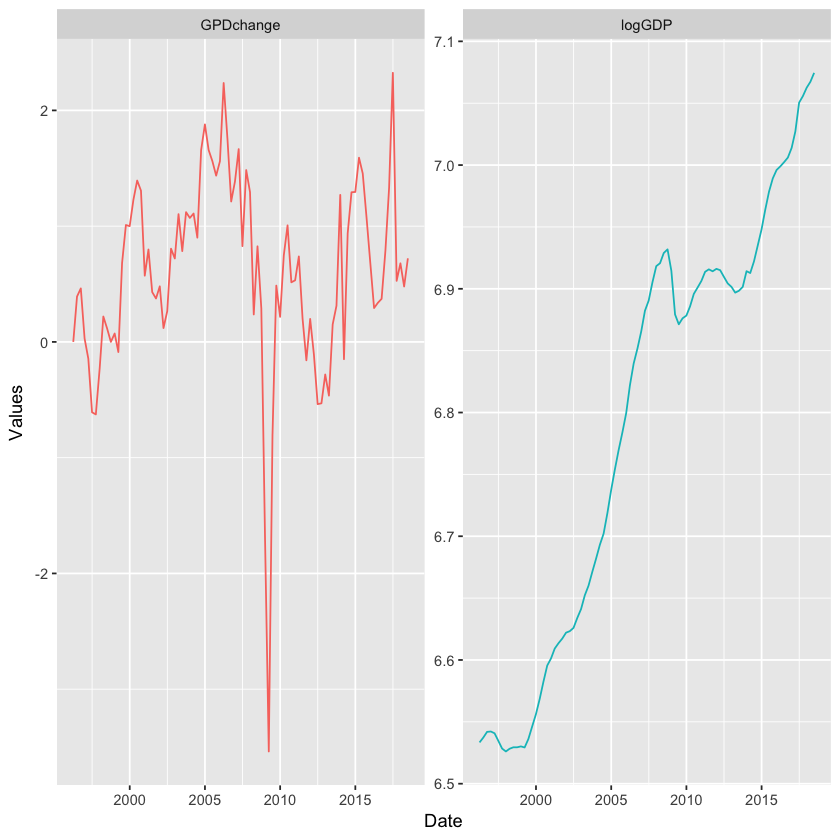

In [63]:
# BCT Winter 2018
# November 14, 2018
# STATE-SPACE MODELS AND KALMAN FILTER

# FULL TREND-CYCLE WITH ESTIMATION

#### HOUSEKEEPING ####
rm(list = ls())

#### DATA ####
library(readxl)
gdp   <- na.omit(read_excel("gdpCZ.xlsx"))
dates <- gdp$period
gdp   <- log(gdp$value)
gdpG  <- c(0,diff(gdp))

# Prepare nice ggplot #
library(ggplot2)
data.plot = data.frame(Date = rep(dates,2),
                       Category = rep(c("logGDP","GPDchange"), each=length(gdp)),
                       Values = c(gdp,gdpG*100))

ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                              geom_line(aes(color=Category)) + 
                       facet_wrap(~ Category, scales='free') + 
                               theme(legend.position="none")
#### STORY ####
# some of the dynamics is driven by potential GDP, some by some cyclical fluctuations (GDP gap)
# we are interested in the potential, which is, however, unobservable
# consequently, we will try to estimate the potential as a state variable in the state-space model

#### MACRO-MODELLING ####

# SPACE of models --> model selection --> parameter estimation

# ARIMA models ... I have a small SPACE of possible models defined by the AR/MA/D orders
#                  the only structure imposed is that the residuals are white noise
#                  otherwise all is data-driven (ACF/PACF, residual diagnostics, ...)
# State space model ... infinitelly large structure of possible models
#                       the models are defined by the set of 


#### MODEL ####


# 1) MEASUREMENT EQUATION:  

#   y(t)   =     H       *    X(t)      + v(t);   v(t) ~ N(0,R)  
#
#   gpd    =  transformation of states  + measurement error
#
#                          |TREND(t)  |
#   y(t)   =  [h1 h2 h3] * |CYCLE(t)  | + v(t);   v(t) ~ N(0,sigmaR)  
#                          |CYCLE(t-1)|


# 2) TRANSITION EQUATION:  

#     X(t)    =      A   +        F        *     X(t-1)     +    u(t);  u(t) ~ N(0,Q)  

# |TREND(t)  |     |a1|     |f11 f12 f13|     |TREND(t-1)|     |u1(t)|             |sigmaQ1 0 0|
# |CYCLE(t)  |  =  |a2|  +  |f21 f22 f23|  *  |CYCLE(t-1)|  +  |u2(t)|; u(t) ~ N(0,|0 sigmaQ2 0|)  
# |CYCLE(t-1)|     |a3|     |f21 f22 f33|     |CYCLE(t-2)|     |u3(t)|;            |0 0 sigmaQ3|  

#   factors   =    some dynamic process                     +  transition (state) error


# 3) RESTRICTIONS - to identify the model:

# if not, infinity of equivalent models exist:
#     - states fluctuating around 1000 and H parameters of a degree 0.01
#     - states fluctuating around  100 and H parameters of a degree 0.10
#     - states fluctuating around   10 and H parameters of a degree 1.00
#     - etc.
# => estimation would not converge!!

# restrictions on measurement equation:
# - h1 = 1, h2 = 1, h3 = 0
# - R is zero

# restrictions on transition equation:
# - trend equation:        f11 = 1, f12 = f13 = 0 
# - cycle equation:        f21 = 0
# - lagged cycle identity: f32 = 1, f31 = f33 = a3 = 0
# - Q is diagonal

# restriction on the relation u and v:
# u(t) and v(t) have zero covariance

#####################################################################################3

a1      = mean(diff(gdp)) 
a2      = 0
sigmaQ1 = log(sd(diff(gdp))^2)  
sigmaQ2 = log(sd(diff(gdp))^2)  
f22in   = 2  
f23in   = 2  
 
theta = c(a1, a2, sigmaQ1, sigmaQ2, f22in, f23in)
 
data   = gdp
pers  <- length(data)
 
HH = matrix(c(1, 1, 0), ncol = 3)
AA = matrix(c(theta[1:2],0), ncol = 1)
RR = 10
QQ = diag(c(5,5))

f22ad = theta[5]/(1+abs(theta[5]))
f23ad = theta[6]/(1+abs(theta[6]))
f22   = f22ad + f23ad
f23   = -f22ad*f23ad
FF    = matrix(c( 1 , 0 , 0 ,
                  0 ,f22,f23,
                  0 , 1 , 0),byrow = T, ncol = 3)

X0 = c(data[1]-theta[1],0,0)  
P0 = 10*QQ      

states0 = matrix(NA,nrow = pers, ncol = 3)
states1 = matrix(NA,nrow = pers, ncol = 3)

stVars0 = array(NA,dim = c(pers,3,3))
stVars1 = array(NA,dim = c(pers,3,3))

for (tt in 1:pers){
 
  X1pred = AA + FF%*%X0           
  P1pred = FF%*%P0%*%t(FF) + QQ    
  YYpred = HH%*%X1pred            
  
  states0[tt,]  = X1pred
  stVars0[tt,,] = P1pred
  
  YYerror = data[tt] - YYpred      
  
  obsVAR = HH%*%P1pred%*%t(HH) + RR       
  KG     = P1pred%*%t(HH)%*%(solve(obsVAR)^(-1)) 
  X1     = X1pred + KG%*%YYerror         
  P1     = P1pred - KG%*%HH%*%P1pred       
 
  states1[tt,] = X1
  stVars1[tt,,] = P1
  
  X0 = X1
  P0 = P1
}

data.plot = data.frame(Date = rep(dates,3),
                       Category = rep(c("Real GDP","Potential GDP","GDP Gap"), each=pers),
                       Plottt = c(rep("GDP and Potential GDP (quarterly, mld. CZK)",2*pers),rep("GDP Gap (%)",pers)),
                       Values = c(exp(gdp),exp(states1[,1]),states1[,2]*100))

ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                              geom_line(aes(color=Category)) + 
               facet_wrap(~ Plottt, ncol = 1, scales='free') +
                                             theme_classic() + 
  geom_hline(aes(yintercept=int), data.frame(int=c(0),Plottt=c("GDP Gap (%)")), color="red",lty=2)

kalmanFUN <- function(theta, data, type){

  pers  <- length(data)
  
  HH = matrix(c(1, 1, 0), ncol = 3)
  AA = matrix(c(theta[1:2],0), ncol = 1)
    RR = 10
    QQ = diag(c(5,5))
  
  f22ad = theta[5]/(1+abs(theta[5]))
  f23ad = theta[6]/(1+abs(theta[6]))
  f22   = f22ad + f23ad
  f23   = -f22ad*f23ad
  FF    = matrix(c( 1 , 0 , 0 ,
                 0 ,f22,f23,
                 0 , 1 , 0),byrow = T, ncol = 3)
  
  X0 = c(data[1]-theta[1],0,0)  
  P0 = 10*QQ              
  
  states0 = matrix(NA,nrow = pers, ncol = 3)
  states1 = matrix(NA,nrow = pers, ncol = 3)
  
  stVars0 = array(NA,dim = c(pers,3,3))
  stVars1 = array(NA,dim = c(pers,3,3))
  
  loglk = 0
  
  for (tt in 1:pers){
    
    X1pred = AA + FF%*%X0            
    P1pred = FF%*%P0%*%t(FF) + QQ 
    YYpred = HH%*%X1pred             
    
    states0[tt,] = X1pred
    stVars0[tt,,] = P1pred
    
    YYerror = data[tt] - YYpred         
    obsVAR = HH%*%P1pred%*%t(HH) + RR   
    
    if (rcond(obsVAR) > 1e-10){
      loglk = loglk - 1/2*(log(2*pi) + log(det(obsVAR)) + t(YYerror) %*% solve(obsVAR) %*% YYerror) #see slide 14
    }else{  
      loglk = loglk - 1e50
      break
    }
    
    KG     = P1pred%*%t(HH)%*%(solve(obsVAR)^(-1))  
    X1     = X1pred + KG%*%YYerror                  
    P1     = P1pred - KG%*%HH%*%P1pred            
    
    states1[tt,]  = X1
    stVars1[tt,,] = P1
    
    X0 = X1
    P0 = P1
  }

  negLogLik = -loglk
   
  if (type == "MLE"){
    return(negLogLik) 
  } else {
    output = list()
    output$states0 = states0
    output$states1 = states1
    output$stVars0 = stVars0
    output$stVars1 = stVars1
    output$FF = FF
    return(output)
  }
}

library("MASS")
kalmanSMTH <- function(output){

  states0 = output$states0
  states1 = output$states1
  stVars0 = output$stVars0
  stVars1 = output$stVars1
  
  FF = output$FF
  
  pers = dim(states0)[1]
  
  statesSmooth         = matrix(NA,nrow = pers, ncol = 3)
  statesSmooth[pers,]  = states1[pers,]
  stVarsSmooth         = array(NA,dim = c(pers,3,3))
  stVarsSmooth[pers,,] = stVars1[pers,,]
  
  for (tt in seq(from  = pers-1, to = 1, by = -1)){
                   VV  = stVars1[tt,,] %*% t(FF) %*% ginv(stVars1[tt+1,,])
    statesSmooth[tt,]  = states1[tt,]  + VV%*%(statesSmooth[tt+1,] -states0[tt+1,])
    stVarsSmooth[tt,,] = stVars1[tt,,] + VV%*%(stVarsSmooth[tt+1,,]-stVars0[tt+1,,])%*%t(VV)
  }
  return(statesSmooth)
}

kalmanFUN(theta, gdp, "MLE")          
outInit <- kalmanFUN(theta, gdp, "X")  
statesF <- outInit$states1
statesS <- kalmanSMTH(outInit)

data.plot = data.frame(
  Date     = rep(dates,5),
  Category = rep(c("Real GDP",
                   "Potential GDP (FILT)",
                   "GDP Gap (FILT)",
                   "Potential GDP (SMOO)",
                   "GDP Gap (SMOO)"),each=pers),
  Plottt   = rep(c("GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)"),each=pers),
  Values = c(exp(gdp),
             exp(statesF[,1]),
             statesF[,2]*100,
             exp(statesS[,1]),
             statesS[,2]*100)
)

ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                              geom_line(aes(color=Category)) + 
               facet_wrap(~ Plottt, ncol = 1, scales='free') + 
                                             theme_classic() + 
  geom_hline(aes(yintercept=int), data.frame(int=c(0),Plottt=c("GDP Gap (%)")), color="red",lty=2)

parOpt <- optim(theta, kalmanFUN, gr = NULL, gdp, "MLE", control = list(trace = 3, maxit = 5000), 
                method = "Nelder-Mead")

thetaO = parOpt$par

print(theta)
print(thetaO)

outFin     <- kalmanFUN(thetaO, gdp, "X")  
statesFinF <- outFin$states1
statesFinS <- kalmanSMTH(outFin)

data.plot  = data.frame(
  Date     = rep(dates,5),
  Category = rep(c("Real GDP",
                   "Potential GDP (FILT)",
                   "GDP Gap (FILT)",
                   "Potential GDP (SMOO)",
                   "GDP Gap (SMOO)"),each=pers),
  Plottt   = rep(c("GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)"),each=pers),
  Values = c(exp(gdp),
             exp(statesFinF[,1]),
             statesFinF[,2]*100,
             exp(statesFinS[,1]),
             statesFinS[,2]*100)
)

ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                              geom_line(aes(color=Category)) + 
               facet_wrap(~ Plottt, ncol = 1, scales='free') + 
                                             theme_classic() + 
  geom_hline(aes(yintercept=int), data.frame(int=c(0),Plottt=c("GDP Gap (%)")), color="red",lty=2)

HH = matrix(c(1, 1, 0), ncol = 3)
AA = matrix(c(thetaO[1:2],0), ncol = 1)
    RR = 10
    QQ = diag(c(5,5))

f22ad = thetaO[5]/(1+abs(thetaO[5]))
f23ad = thetaO[6]/(1+abs(thetaO[6]))
f22   = f22ad + f23ad
f23   = -f22ad*f23ad
FF    = matrix(c( 1 , 0 , 0 ,
                  0 ,f22,f23,
                  0 , 1 , 0),byrow = T, ncol = 3)




ERROR: Error in FF %*% P0: non-conformable arguments


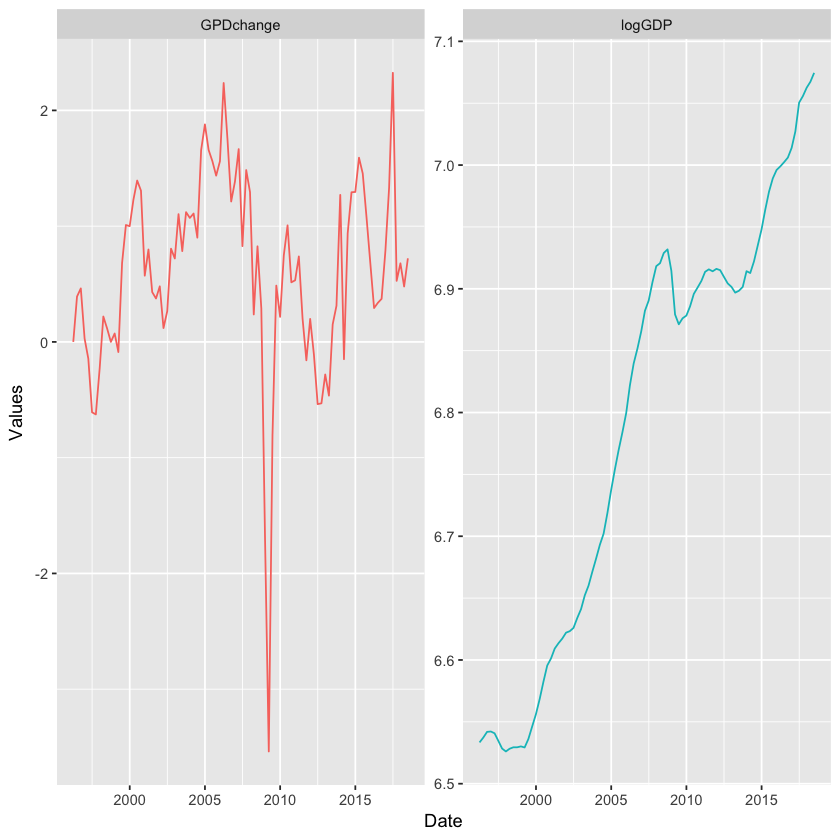

In [63]:
# BCT Winter 2018
# November 14, 2018
# STATE-SPACE MODELS AND KALMAN FILTER

# FULL TREND-CYCLE WITH ESTIMATION

#### HOUSEKEEPING ####
rm(list = ls())

#### DATA ####
library(readxl)
gdp   <- na.omit(read_excel("gdpCZ.xlsx"))
dates <- gdp$period
gdp   <- log(gdp$value)
gdpG  <- c(0,diff(gdp))

# Prepare nice ggplot #
library(ggplot2)
data.plot = data.frame(Date = rep(dates,2),
                       Category = rep(c("logGDP","GPDchange"), each=length(gdp)),
                       Values = c(gdp,gdpG*100))

ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                              geom_line(aes(color=Category)) + 
                       facet_wrap(~ Category, scales='free') + 
                               theme(legend.position="none")
#### STORY ####
# some of the dynamics is driven by potential GDP, some by some cyclical fluctuations (GDP gap)
# we are interested in the potential, which is, however, unobservable
# consequently, we will try to estimate the potential as a state variable in the state-space model

#### MACRO-MODELLING ####

# SPACE of models --> model selection --> parameter estimation

# ARIMA models ... I have a small SPACE of possible models defined by the AR/MA/D orders
#                  the only structure imposed is that the residuals are white noise
#                  otherwise all is data-driven (ACF/PACF, residual diagnostics, ...)
# State space model ... infinitelly large structure of possible models
#                       the models are defined by the set of 


#### MODEL ####


# 1) MEASUREMENT EQUATION:  

#   y(t)   =     H       *    X(t)      + v(t);   v(t) ~ N(0,R)  
#
#   gpd    =  transformation of states  + measurement error
#
#                          |TREND(t)  |
#   y(t)   =  [h1 h2 h3] * |CYCLE(t)  | + v(t);   v(t) ~ N(0,sigmaR)  
#                          |CYCLE(t-1)|


# 2) TRANSITION EQUATION:  

#     X(t)    =      A   +        F        *     X(t-1)     +    u(t);  u(t) ~ N(0,Q)  

# |TREND(t)  |     |a1|     |f11 f12 f13|     |TREND(t-1)|     |u1(t)|             |sigmaQ1 0 0|
# |CYCLE(t)  |  =  |a2|  +  |f21 f22 f23|  *  |CYCLE(t-1)|  +  |u2(t)|; u(t) ~ N(0,|0 sigmaQ2 0|)  
# |CYCLE(t-1)|     |a3|     |f21 f22 f33|     |CYCLE(t-2)|     |u3(t)|;            |0 0 sigmaQ3|  

#   factors   =    some dynamic process                     +  transition (state) error


# 3) RESTRICTIONS - to identify the model:

# if not, infinity of equivalent models exist:
#     - states fluctuating around 1000 and H parameters of a degree 0.01
#     - states fluctuating around  100 and H parameters of a degree 0.10
#     - states fluctuating around   10 and H parameters of a degree 1.00
#     - etc.
# => estimation would not converge!!

# restrictions on measurement equation:
# - h1 = 1, h2 = 1, h3 = 0
# - R is zero

# restrictions on transition equation:
# - trend equation:        f11 = 1, f12 = f13 = 0 
# - cycle equation:        f21 = 0
# - lagged cycle identity: f32 = 1, f31 = f33 = a3 = 0
# - Q is diagonal

# restriction on the relation u and v:
# u(t) and v(t) have zero covariance

#####################################################################################3

a1      = mean(diff(gdp)) 
a2      = 0
sigmaQ1 = log(sd(diff(gdp))^2)  
sigmaQ2 = log(sd(diff(gdp))^2)  
f22in   = 2  
f23in   = 2  
 
theta = c(a1, a2, sigmaQ1, sigmaQ2, f22in, f23in)
 
data   = gdp
pers  <- length(data)
 
HH = matrix(c(1, 1, 0), ncol = 3)
AA = matrix(c(theta[1:2],0), ncol = 1)
RR = 10
QQ = diag(c(5,5))

f22ad = theta[5]/(1+abs(theta[5]))
f23ad = theta[6]/(1+abs(theta[6]))
f22   = f22ad + f23ad
f23   = -f22ad*f23ad
FF    = matrix(c( 1 , 0 , 0 ,
                  0 ,f22,f23,
                  0 , 1 , 0),byrow = T, ncol = 3)

X0 = c(data[1]-theta[1],0,0)  
P0 = 10*QQ      

states0 = matrix(NA,nrow = pers, ncol = 3)
states1 = matrix(NA,nrow = pers, ncol = 3)

stVars0 = array(NA,dim = c(pers,3,3))
stVars1 = array(NA,dim = c(pers,3,3))

for (tt in 1:pers){
 
  X1pred = AA + FF%*%X0           
  P1pred = FF%*%P0%*%t(FF) + QQ    
  YYpred = HH%*%X1pred            
  
  states0[tt,]  = X1pred
  stVars0[tt,,] = P1pred
  
  YYerror = data[tt] - YYpred      
  
  obsVAR = HH%*%P1pred%*%t(HH) + RR       
  KG     = P1pred%*%t(HH)%*%(solve(obsVAR)^(-1)) 
  X1     = X1pred + KG%*%YYerror         
  P1     = P1pred - KG%*%HH%*%P1pred       
 
  states1[tt,] = X1
  stVars1[tt,,] = P1
  
  X0 = X1
  P0 = P1
}

data.plot = data.frame(Date = rep(dates,3),
                       Category = rep(c("Real GDP","Potential GDP","GDP Gap"), each=pers),
                       Plottt = c(rep("GDP and Potential GDP (quarterly, mld. CZK)",2*pers),rep("GDP Gap (%)",pers)),
                       Values = c(exp(gdp),exp(states1[,1]),states1[,2]*100))

ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                              geom_line(aes(color=Category)) + 
               facet_wrap(~ Plottt, ncol = 1, scales='free') +
                                             theme_classic() + 
  geom_hline(aes(yintercept=int), data.frame(int=c(0),Plottt=c("GDP Gap (%)")), color="red",lty=2)

kalmanFUN <- function(theta, data, type){

  pers  <- length(data)
  
  HH = matrix(c(1, 1, 0), ncol = 3)
  AA = matrix(c(theta[1:2],0), ncol = 1)
    RR = 10
    QQ = diag(c(5,5))
  
  f22ad = theta[5]/(1+abs(theta[5]))
  f23ad = theta[6]/(1+abs(theta[6]))
  f22   = f22ad + f23ad
  f23   = -f22ad*f23ad
  FF    = matrix(c( 1 , 0 , 0 ,
                 0 ,f22,f23,
                 0 , 1 , 0),byrow = T, ncol = 3)
  
  X0 = c(data[1]-theta[1],0,0)  
  P0 = 10*QQ              
  
  states0 = matrix(NA,nrow = pers, ncol = 3)
  states1 = matrix(NA,nrow = pers, ncol = 3)
  
  stVars0 = array(NA,dim = c(pers,3,3))
  stVars1 = array(NA,dim = c(pers,3,3))
  
  loglk = 0
  
  for (tt in 1:pers){
    
    X1pred = AA + FF%*%X0            
    P1pred = FF%*%P0%*%t(FF) + QQ 
    YYpred = HH%*%X1pred             
    
    states0[tt,] = X1pred
    stVars0[tt,,] = P1pred
    
    YYerror = data[tt] - YYpred         
    obsVAR = HH%*%P1pred%*%t(HH) + RR   
    
    if (rcond(obsVAR) > 1e-10){
      loglk = loglk - 1/2*(log(2*pi) + log(det(obsVAR)) + t(YYerror) %*% solve(obsVAR) %*% YYerror) #see slide 14
    }else{  
      loglk = loglk - 1e50
      break
    }
    
    KG     = P1pred%*%t(HH)%*%(solve(obsVAR)^(-1))  
    X1     = X1pred + KG%*%YYerror                  
    P1     = P1pred - KG%*%HH%*%P1pred            
    
    states1[tt,]  = X1
    stVars1[tt,,] = P1
    
    X0 = X1
    P0 = P1
  }

  negLogLik = -loglk
   
  if (type == "MLE"){
    return(negLogLik) 
  } else {
    output = list()
    output$states0 = states0
    output$states1 = states1
    output$stVars0 = stVars0
    output$stVars1 = stVars1
    output$FF = FF
    return(output)
  }
}

library("MASS")
kalmanSMTH <- function(output){

  states0 = output$states0
  states1 = output$states1
  stVars0 = output$stVars0
  stVars1 = output$stVars1
  
  FF = output$FF
  
  pers = dim(states0)[1]
  
  statesSmooth         = matrix(NA,nrow = pers, ncol = 3)
  statesSmooth[pers,]  = states1[pers,]
  stVarsSmooth         = array(NA,dim = c(pers,3,3))
  stVarsSmooth[pers,,] = stVars1[pers,,]
  
  for (tt in seq(from  = pers-1, to = 1, by = -1)){
                   VV  = stVars1[tt,,] %*% t(FF) %*% ginv(stVars1[tt+1,,])
    statesSmooth[tt,]  = states1[tt,]  + VV%*%(statesSmooth[tt+1,] -states0[tt+1,])
    stVarsSmooth[tt,,] = stVars1[tt,,] + VV%*%(stVarsSmooth[tt+1,,]-stVars0[tt+1,,])%*%t(VV)
  }
  return(statesSmooth)
}

kalmanFUN(theta, gdp, "MLE")          
outInit <- kalmanFUN(theta, gdp, "X")  
statesF <- outInit$states1
statesS <- kalmanSMTH(outInit)

data.plot = data.frame(
  Date     = rep(dates,5),
  Category = rep(c("Real GDP",
                   "Potential GDP (FILT)",
                   "GDP Gap (FILT)",
                   "Potential GDP (SMOO)",
                   "GDP Gap (SMOO)"),each=pers),
  Plottt   = rep(c("GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)"),each=pers),
  Values = c(exp(gdp),
             exp(statesF[,1]),
             statesF[,2]*100,
             exp(statesS[,1]),
             statesS[,2]*100)
)

ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                              geom_line(aes(color=Category)) + 
               facet_wrap(~ Plottt, ncol = 1, scales='free') + 
                                             theme_classic() + 
  geom_hline(aes(yintercept=int), data.frame(int=c(0),Plottt=c("GDP Gap (%)")), color="red",lty=2)

parOpt <- optim(theta, kalmanFUN, gr = NULL, gdp, "MLE", control = list(trace = 3, maxit = 5000), 
                method = "Nelder-Mead")

thetaO = parOpt$par

print(theta)
print(thetaO)

outFin     <- kalmanFUN(thetaO, gdp, "X")  
statesFinF <- outFin$states1
statesFinS <- kalmanSMTH(outFin)

data.plot  = data.frame(
  Date     = rep(dates,5),
  Category = rep(c("Real GDP",
                   "Potential GDP (FILT)",
                   "GDP Gap (FILT)",
                   "Potential GDP (SMOO)",
                   "GDP Gap (SMOO)"),each=pers),
  Plottt   = rep(c("GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)",
                   "GDP and Potential GDP (quarterly, mld. CZK)",
                   "GDP Gap (%)"),each=pers),
  Values = c(exp(gdp),
             exp(statesFinF[,1]),
             statesFinF[,2]*100,
             exp(statesFinS[,1]),
             statesFinS[,2]*100)
)

ggplot(data=data.plot,aes(x=Date, y=Values, group=Category)) +
                              geom_line(aes(color=Category)) + 
               facet_wrap(~ Plottt, ncol = 1, scales='free') + 
                                             theme_classic() + 
  geom_hline(aes(yintercept=int), data.frame(int=c(0),Plottt=c("GDP Gap (%)")), color="red",lty=2)

HH = matrix(c(1, 1, 0), ncol = 3)
AA = matrix(c(thetaO[1:2],0), ncol = 1)
    RR = 10
    QQ = diag(c(5,5))

f22ad = thetaO[5]/(1+abs(thetaO[5]))
f23ad = thetaO[6]/(1+abs(thetaO[6]))
f22   = f22ad + f23ad
f23   = -f22ad*f23ad
FF    = matrix(c( 1 , 0 , 0 ,
                  0 ,f22,f23,
                  0 , 1 , 0),byrow = T, ncol = 3)


